In [1]:
import os
import json
import base64
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog

# NY MSA Test

## Overture Maps with Google Maps

In [2]:
ny_gplc_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_ove.geojson')

In [7]:
ny_gplc_ove['is_true_match'].notna().sum() / len(ny_gplc_ove)

0.8166565164433618

In [6]:
ny_gplc_ove['is_true_match'].value_counts()

is_true_match
1    46493
0     7145
Name: count, dtype: int64

## Safegraph with Google Maps

In [3]:
ny_gplc_sf = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_sf.geojson')

In [11]:
ny_gplc_sf['is_true_match'].notna().sum() 

51706

In [8]:
ny_gplc_sf['is_true_match'].notna().sum() / len(ny_gplc_sf)

0.7872411693057247

In [17]:
ny_gplc_sf[ny_gplc_sf['is_true_match'] == '1'].shape[0]

46717

In [18]:
ny_gplc_sf[ny_gplc_sf['is_true_match'] == '1'].shape[0] / len(ny_gplc_sf)

0.7112819732034105

## Foursquaer with Google Maps

In [4]:
ny_gplc_fsq = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_fsq.geojson')

In [19]:
ny_gplc_fsq['is_true_match'].notna().sum() 

54020

In [20]:
ny_gplc_fsq['is_true_match'].notna().sum()  / len(ny_gplc_fsq)

0.8224725943970768

In [22]:
ny_gplc_fsq[ny_gplc_fsq['is_true_match'] == '1'].shape[0]

43745

In [23]:
ny_gplc_fsq[ny_gplc_fsq['is_true_match'] == '1'].shape[0] / len(ny_gplc_fsq)

0.6660322777101096

## OSM with Google Maps

## Overture Maps resturant with Department of Health and Mental Hygiene(DOHMH)

In [91]:
nyc_c_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_c_ove_restaurant.geojson')

## Google Maps food with DOHMH

In [92]:
ny_gplc_c = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_golc_c.geojson')

# Prepare the functions

In [95]:
def add_distance_bins_to_point(
    gdf,
    ref,
    n_bins=20,
    src_crs="EPSG:4326",
    proj_crs="EPSG:3857",
    dist_col="dist_to_point",
    bin_col="dist_bin"
):

    gdf = gdf.copy()

    # reference point
    pt = ref
    pt_gdf = gpd.GeoDataFrame(geometry=[pt], crs=src_crs)

    # project
    gdf_proj = gdf.to_crs(proj_crs)
    pt_proj = pt_gdf.to_crs(proj_crs)

    # distance (meters)
    gdf[dist_col] = gdf_proj.geometry.distance(pt_proj.geometry.iloc[0]) 

    # bins
    dmin, dmax = gdf[dist_col].min(), gdf[dist_col].max()
    bins = np.linspace(dmin, dmax, n_bins + 1)

    gdf[bin_col] = pd.cut(gdf[dist_col],bins=bins,include_lowest=True)

    return gdf

In [171]:
def summarize_match_miss_by_dist_bin(
    gdf: pd.DataFrame,
    cat_col: str = "primary_cat",
    dist_bin_col: str = "dist_bin",
    true_col: str = "is_true_match",
    match_value= '1',
    name_score_col: str = "name_score", 
    n_mistake_match_col: str = "n_mistake",
    n_first_miss_col: str = "n_miss",
    n_miss_col: str = "n_tot_miss",
    n_match_col: str = "n_match",
    miss_c_col: str = "tot_miss_c",
    match_c_col: str = "tot_match_c",
    miss_density_col: str = "miss_den",
    match_density_col: str = "match_den",
    total_density_col: str = "total_den", 
    median_name_score_col: str = "median_name_score", 
    ring_area_col: str = "ring_area",
    bin_id_col: str = "bin_id",
    area_unit: str = "m2",   # "m2" or "km2"
) -> pd.DataFrame:

    df = gdf.copy()

    # group stats
    df_out = (
        df.groupby([cat_col, dist_bin_col], observed=True)
          .apply(lambda x: pd.Series({
              "n_total": len(x),
              n_match_col: x[true_col].eq(match_value).sum(),
              n_mistake_match_col: x[true_col].eq("0").sum(), # n_mistake_match: true_col == "0"
              n_first_miss_col: x[true_col].isna().sum(), # n_first_miss: true_col 是 NaN
              n_miss_col:  (~x[true_col].eq(match_value)).sum(),  # NaN -> miss
              median_name_score_col: x[name_score_col].median(),
          }))
          .reset_index()
    )

    # proportions within each bin
    df_out[match_c_col] = df_out[n_match_col] / (df_out["n_total"])
    df_out[miss_c_col]  = df_out[n_miss_col]  / (df_out["n_total"])

    # bin order within each category
    df_out[bin_id_col] = df_out.groupby(cat_col, observed=True).cumcount() + 1

    # ring area
    area = df_out[dist_bin_col].apply(lambda x: np.pi * (x.right**2 - x.left**2)).astype(float)
    if area_unit == "km2":
        area = area / 1e6
    df_out[ring_area_col] = area

    # densities (per m² or per km²)
    df_out[miss_density_col]  = df_out[n_miss_col]  / (df_out[ring_area_col])
    df_out[match_density_col] = df_out[n_match_col] / (df_out[ring_area_col])
    df_out[total_density_col] = df_out["n_total"] / (df_out[ring_area_col])
    
    return df_out

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


def plot_dist_bin_bars(
    df,
    y="total_true_match",
    color_col=None,                 
    cmap=plt.cm.coolwarm,
    bar_color="steelblue",          
    primary_cat_col="primary_cat",
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Total number of true matches",
    title="Spatial distribution of true matches by distance to CBD",
    n_cols=4,
    xtick_fontsize=8,
):

    cats = sorted(df[primary_cat_col].unique())
    n_cats = len(cats)
    n_rows = int(np.ceil(n_cats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols + 2.6, 3 * n_rows),
        squeeze=False,
        sharex=True,
        sharey=True,
    )

    # ---------- color normalization (ONLY if needed) ----------
    if color_col is not None:
        norm = mpl.colors.Normalize(
            vmin=df[color_col].min(),
            vmax=df[color_col].max()
        )

    # ---------- draw facets ----------
    for ax, cat in zip(axes.flat, cats):
        df_cat = df[df[primary_cat_col] == cat]

        if color_col is not None:
            colors = cmap(norm(df_cat[color_col]))
        else:
            colors = bar_color

        ax.bar(
            x=df_cat["bin_id"],
            height=df_cat[y],
            color=colors
        )

        ax.set_title(cat)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(df_cat["bin_id"])
        ax.tick_params(axis="x", labelsize=xtick_fontsize)

    # turn off empty axes
    for ax in axes.flat[n_cats:]:
        ax.axis("off")

    # ---------- colorbar (ONLY if color_col exists) ----------
    if color_col is not None:
        cax = fig.add_axes([0.9, 0.4, 0.02, 0.5])

        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label(color_col.replace("_", " ").title())

        right_margin = 0.88
    else:
        right_margin = 0.95

    # ---------- bin legend ----------
    bin_df = (
        df[["bin_id", "dist_bin"]]
        .drop_duplicates()
        .sort_values("bin_id")
    )

    bin_labels = [
        f"Bin {row.bin_id}: {row.dist_bin.left/1000:.1f}–{row.dist_bin.right/1000:.1f} km"
        for _, row in bin_df.iterrows()
    ]

    bin_ax = fig.add_axes([0.9, 0.01, 0.06, 0.3])
    bin_ax.axis("off")

    bin_ax.text(
        0, 1,
        "\n".join(bin_labels),
        va="top",
        ha="left",
        fontsize=8,
    )
    bin_ax.set_title("Distance bins", fontsize=9, pad=4)

    # ---------- title & layout ----------
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, right_margin, 0.95])
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_missmate_by_dist(
    df,
    dens_cols=("match_den", "miss_den", "total_den"),
    colors=None,
    markers=True,
    primary_cat_col="primary_cat",
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Density (per km²)",
    title="Density comparison by distance to CBD",
    n_cols=4,
    xtick_fontsize=8,
    legend_loc="upper right",
):
    """
    Compare multiple density metrics across distance bins using line plots.
    """

    if colors is None:
        colors = {
            "match_den": "#1f77b4",   # blue
            "miss_den":  "#d62728",   # red
            "total_den": "#2ca02c",   # green
        }

    cats = sorted(df[primary_cat_col].unique())
    n_cats = len(cats)
    n_rows = int(np.ceil(n_cats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols + 2.6, 3 * n_rows),
        squeeze=False,
        sharex=True,
        sharey=True
    )

    for ax, cat in zip(axes.flat, cats):
        df_cat = (
            df[df[primary_cat_col] == cat]
            .sort_values("bin_id")
        )

        x = df_cat["bin_id"]

        for col in dens_cols:
            ax.plot(
                x,
                df_cat[col],
                label=col.replace("_", " "),
                color=colors.get(col),
                marker="o" if markers else None,
                linewidth=1.8,
                alpha=0.9,
            )

        ax.set_title(cat)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.tick_params(axis="x", labelsize=xtick_fontsize)

    # turn off empty axes
    for ax in axes.flat[n_cats:]:
        ax.axis("off")

    # shared legend
    handles, labels = axes.flat[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc=legend_loc,
        frameon=False,
        ncol=len(dens_cols)
    )

    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

In [233]:
def summarize_category_match_rate(
    df: pd.DataFrame,
    cat_col: str = "primary_cat",
    true_col: str = "is_true_match",
    true_values=(True, "1"),
    compare_col="ove_count",
    ref_col="google_count",
    cg_m_col: str = "ove_google_m",
    cat_per: str = "cat_per",
) -> pd.DataFrame:
    """
    Summarize Google POI counts, matched Overture counts,
    and match rate by category.
    """

    # ---- matched subset ----
    df_true = df[df[true_col].isin(true_values)]

    # ---- Google category counts (denominator) ----
    g_cat = (
        df[cat_col]
        .value_counts()
        .rename(ref_col)
        .to_frame()
    )
    g_cat[cat_per] = g_cat[ref_col] / len(df)

    # ---- Overture matched category counts (numerator) ----
    o_cat = (
        df_true[cat_col]
        .value_counts()
        .rename(compare_col)
        .to_frame()
    )

    # ---- merge & compute rate ----
    df_out = (
        o_cat
        .merge(g_cat, left_index=True, right_index=True, how="inner")
        .reset_index()
        .rename(columns={"index": cat_col})
        .sort_values(ref_col, ascending=False)
    )

    df_out[cg_m_col] = df_out[compare_col] / df_out[ref_col]

    return df_out

In [248]:
def plot_category_coverage_bars(
    df,
    cat_col="primary_cat",
    compare_col="ove_count",
    ref_col="google_count",
    ratio_col="ove_google_m",
    width=0.35,
    figsize=(16, 6),
    ylabel="POI Count",
    title="Category-level POI match coverage relative to Google Places (reference)",
    rotate_xticks=45,
    ratio_fmt="{:.1f}%",
    ratio_fontsize=7,
):
    """
    Bar chart comparing category-level POI counts and annotating match ratios.
    """
    df = df.reset_index(drop=True)
    x = np.arange(len(df))

    fig, ax = plt.subplots(figsize=figsize)

    bars_ove = ax.bar(
        x,
        df[compare_col],
        width,
        label="Overture"
    )
    bars_google = ax.bar(
        x + width,
        df[ref_col],
        width,
        label="Google Places (reference)"
    )

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(df[cat_col], rotation=rotate_xticks, ha="right")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

    # ---- annotate ratio on overture bars ----
    for i, bar in enumerate(bars_ove):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            ratio_fmt.format(df.loc[i, ratio_col] * 100),
            ha="center",
            va="bottom",
            fontsize=ratio_fontsize
        )

    plt.tight_layout()
    plt.show()

# Findings for Overture Maps with Google Maps

In [158]:
from shapely.geometry import Point
ts_p = Point(-73.98552115962701, 40.757986758482154)

ny_gplc_ove = add_distance_bins_to_point(
    ny_gplc_ove,
    ts_p,
    n_bins=20,
    src_crs="EPSG:4326",
    proj_crs="EPSG:3857",
    dist_col="dist_to_point",
    bin_col="dist_bin"
)

In [276]:
df_all_bins = summarize_match_miss_by_dist_bin(
    ny_gplc_ove,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_mistake_match_col = "n_mistake",
    n_first_miss_col = "n_miss",
    n_miss_col = "n_tot_miss",
    n_match_col = "n_match",
    miss_c_col = "tot_miss_c",
    match_c_col = "tot_match_c",
    miss_density_col = "miss_den",
    match_density_col = "match_den",
    total_density_col = "total_den", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_92644/2926597974.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, right_margin, 0.95])


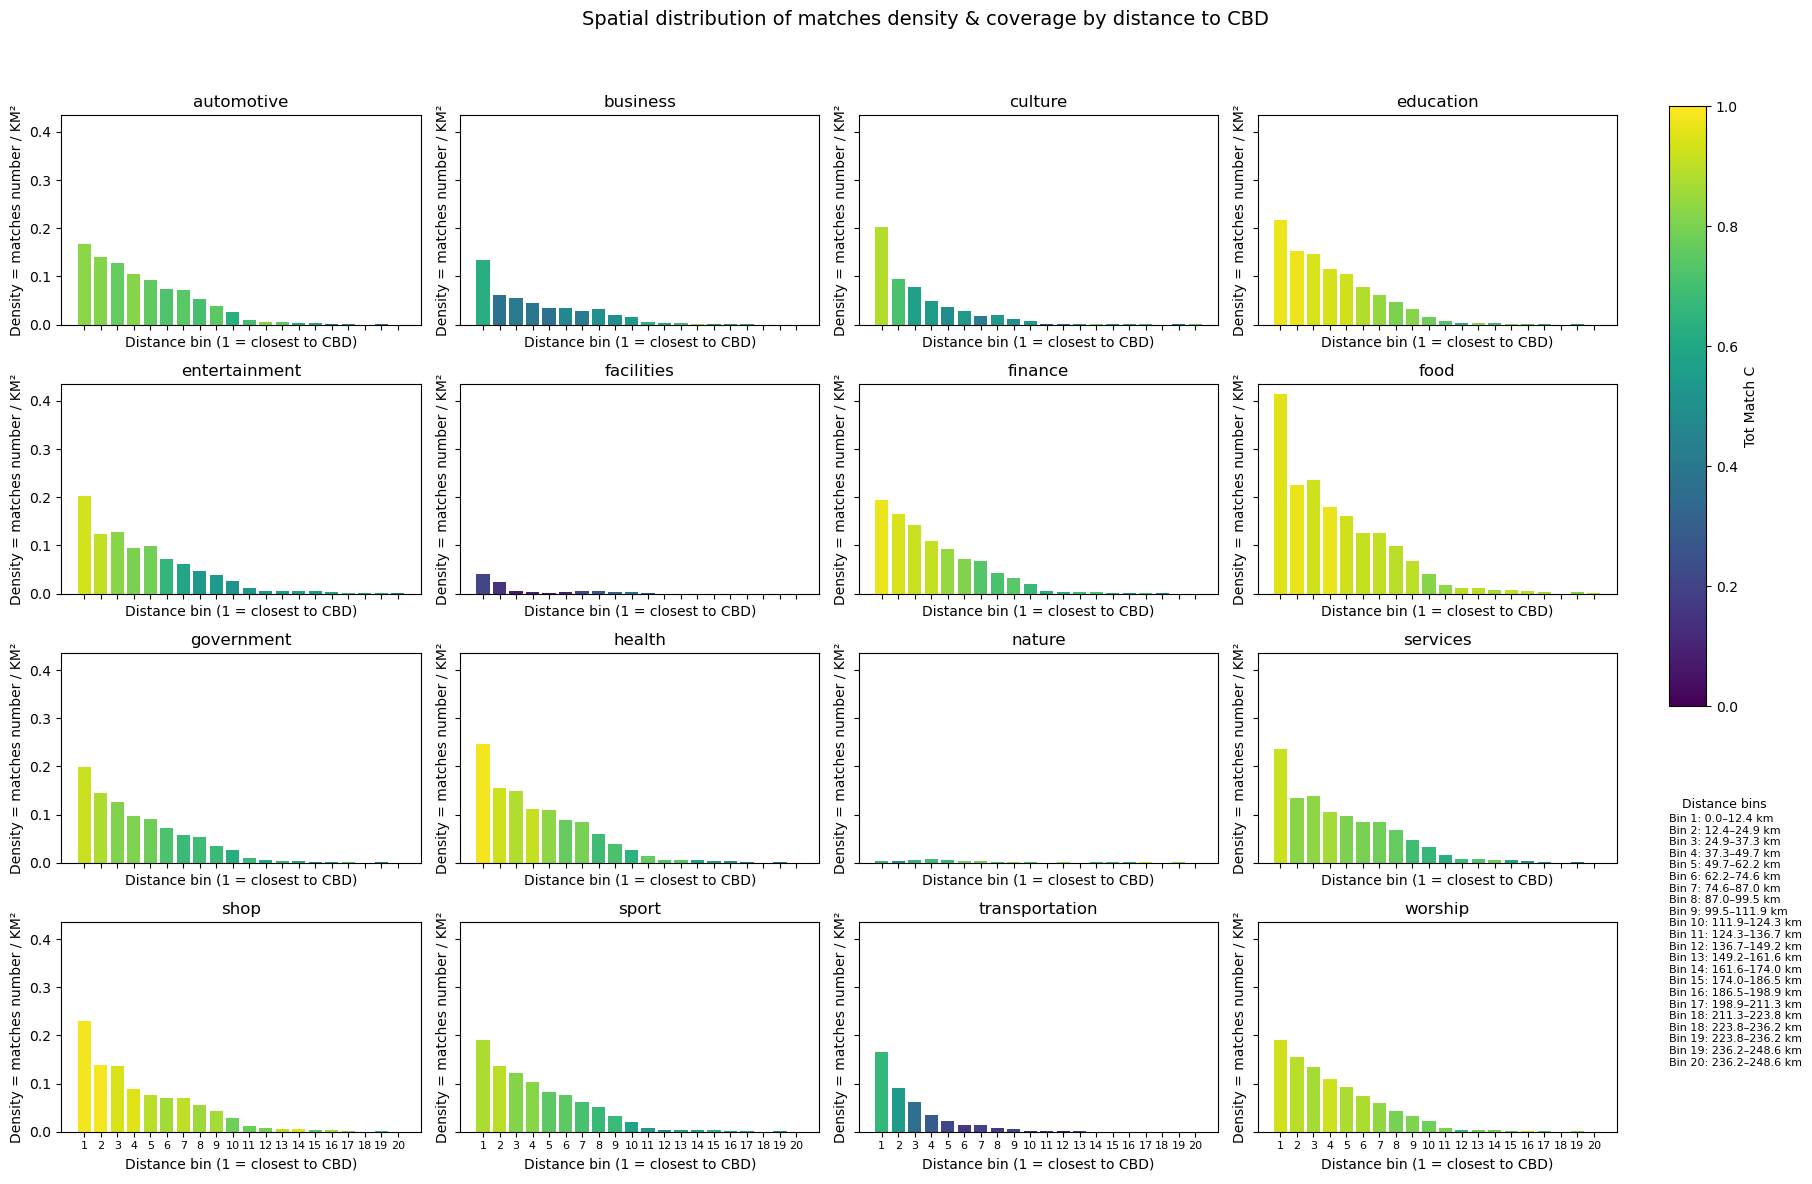

In [277]:
plot_dist_bin_bars(
    df_all_bins,
    color_col="tot_match_c",
    y = 'match_den',
    cmap=plt.cm.viridis,
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Density = matches number / KM²",
    title="Spatial distribution of matches density & coverage by distance to CBD",
    n_cols=4,
    xtick_fontsize=8,
)

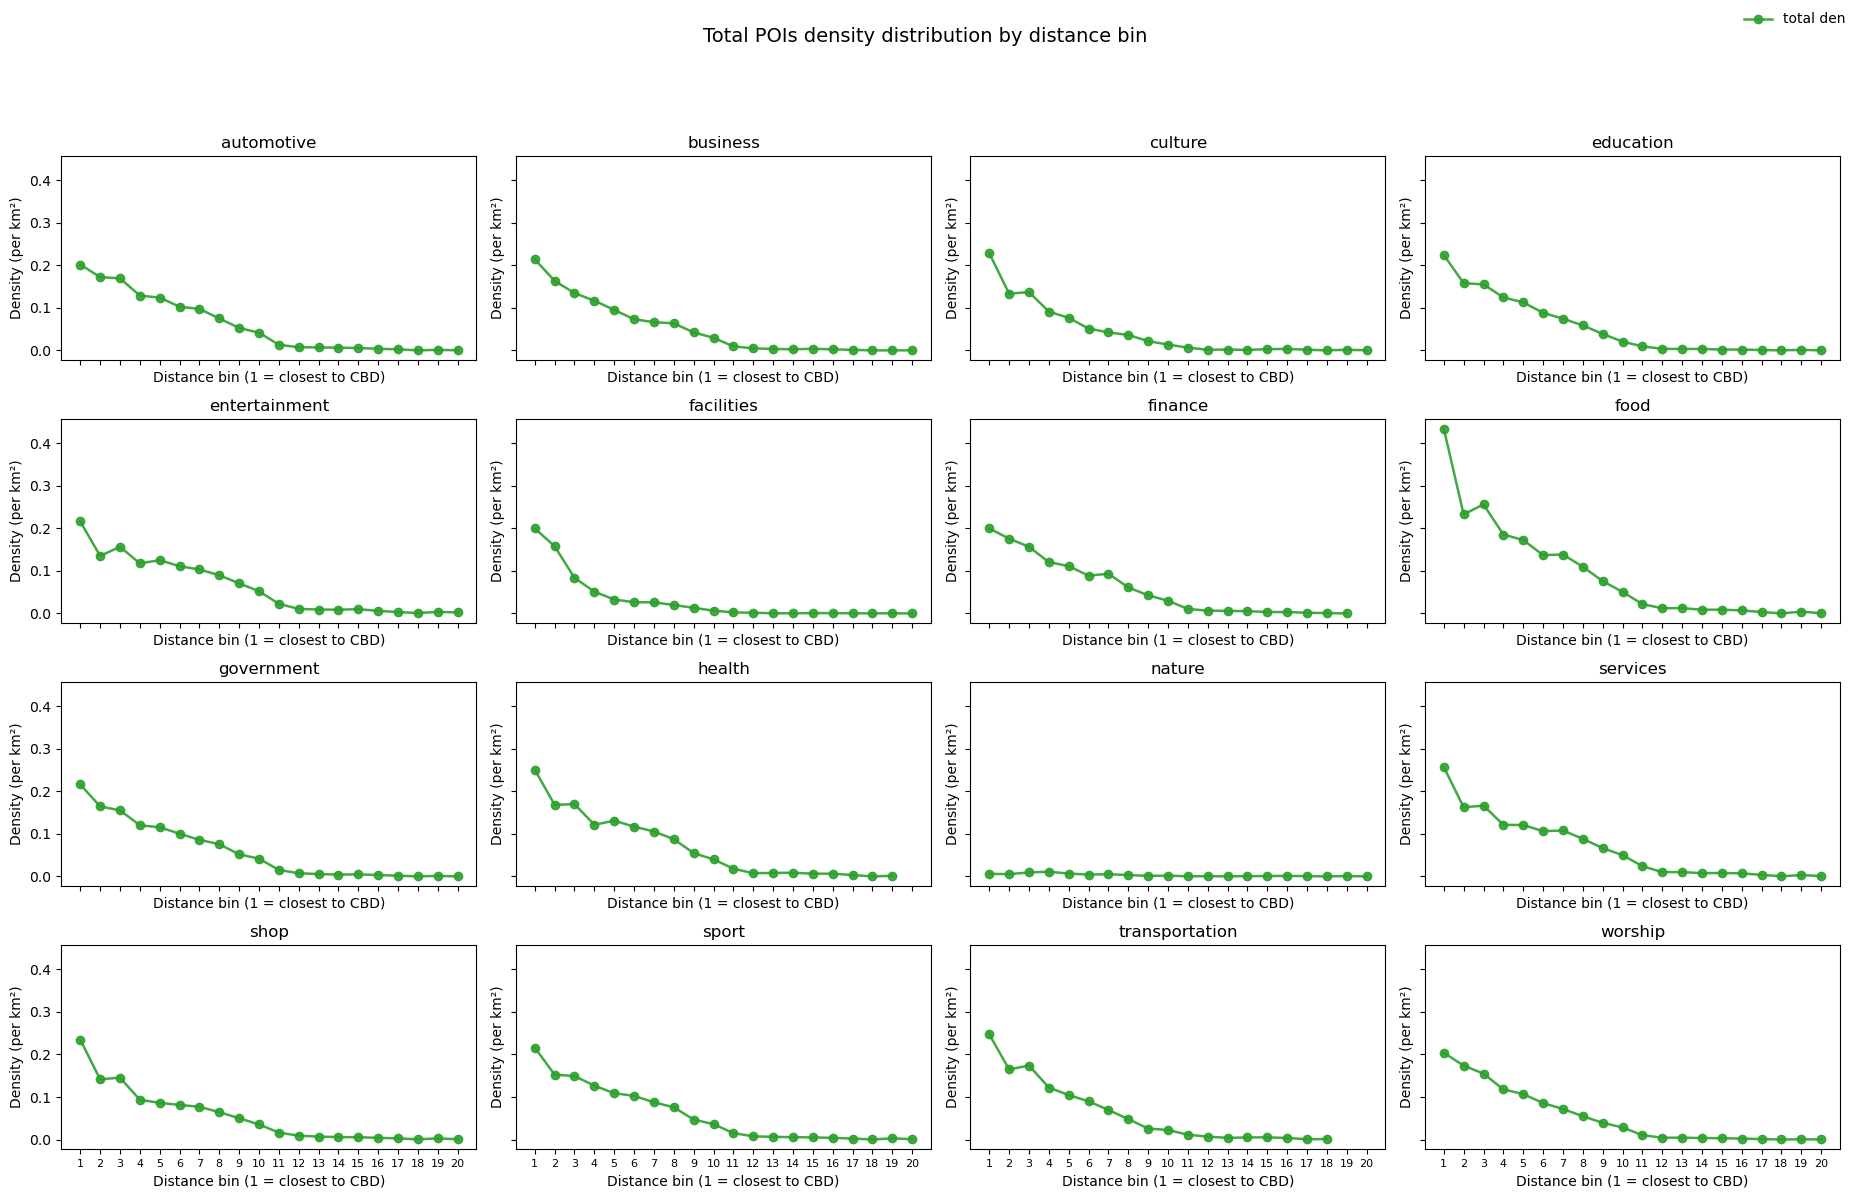

In [176]:
plot_missmate_by_dist(
    df_all_bins,
    dens_cols=("total_den",),
    title="Total POIs density distribution by distance bin"
)

In [279]:
df_all_bins["weight"] = df_all_bins["n_total"] / df_all_bins.groupby("primary_cat")["n_total"].transform("sum")
df_all_bins["w_nonmatch_r"] = df_all_bins["weight"] * df_all_bins["tot_miss_c"]
df_all_bins["w_miss_r"] = df_all_bins["weight"] * (df_all_bins["n_miss"] / df_all_bins["n_total"])
df_all_bins["w_mistake_r"] = df_all_bins["weight"] * (df_all_bins["n_mistake"] / df_all_bins["n_total"])

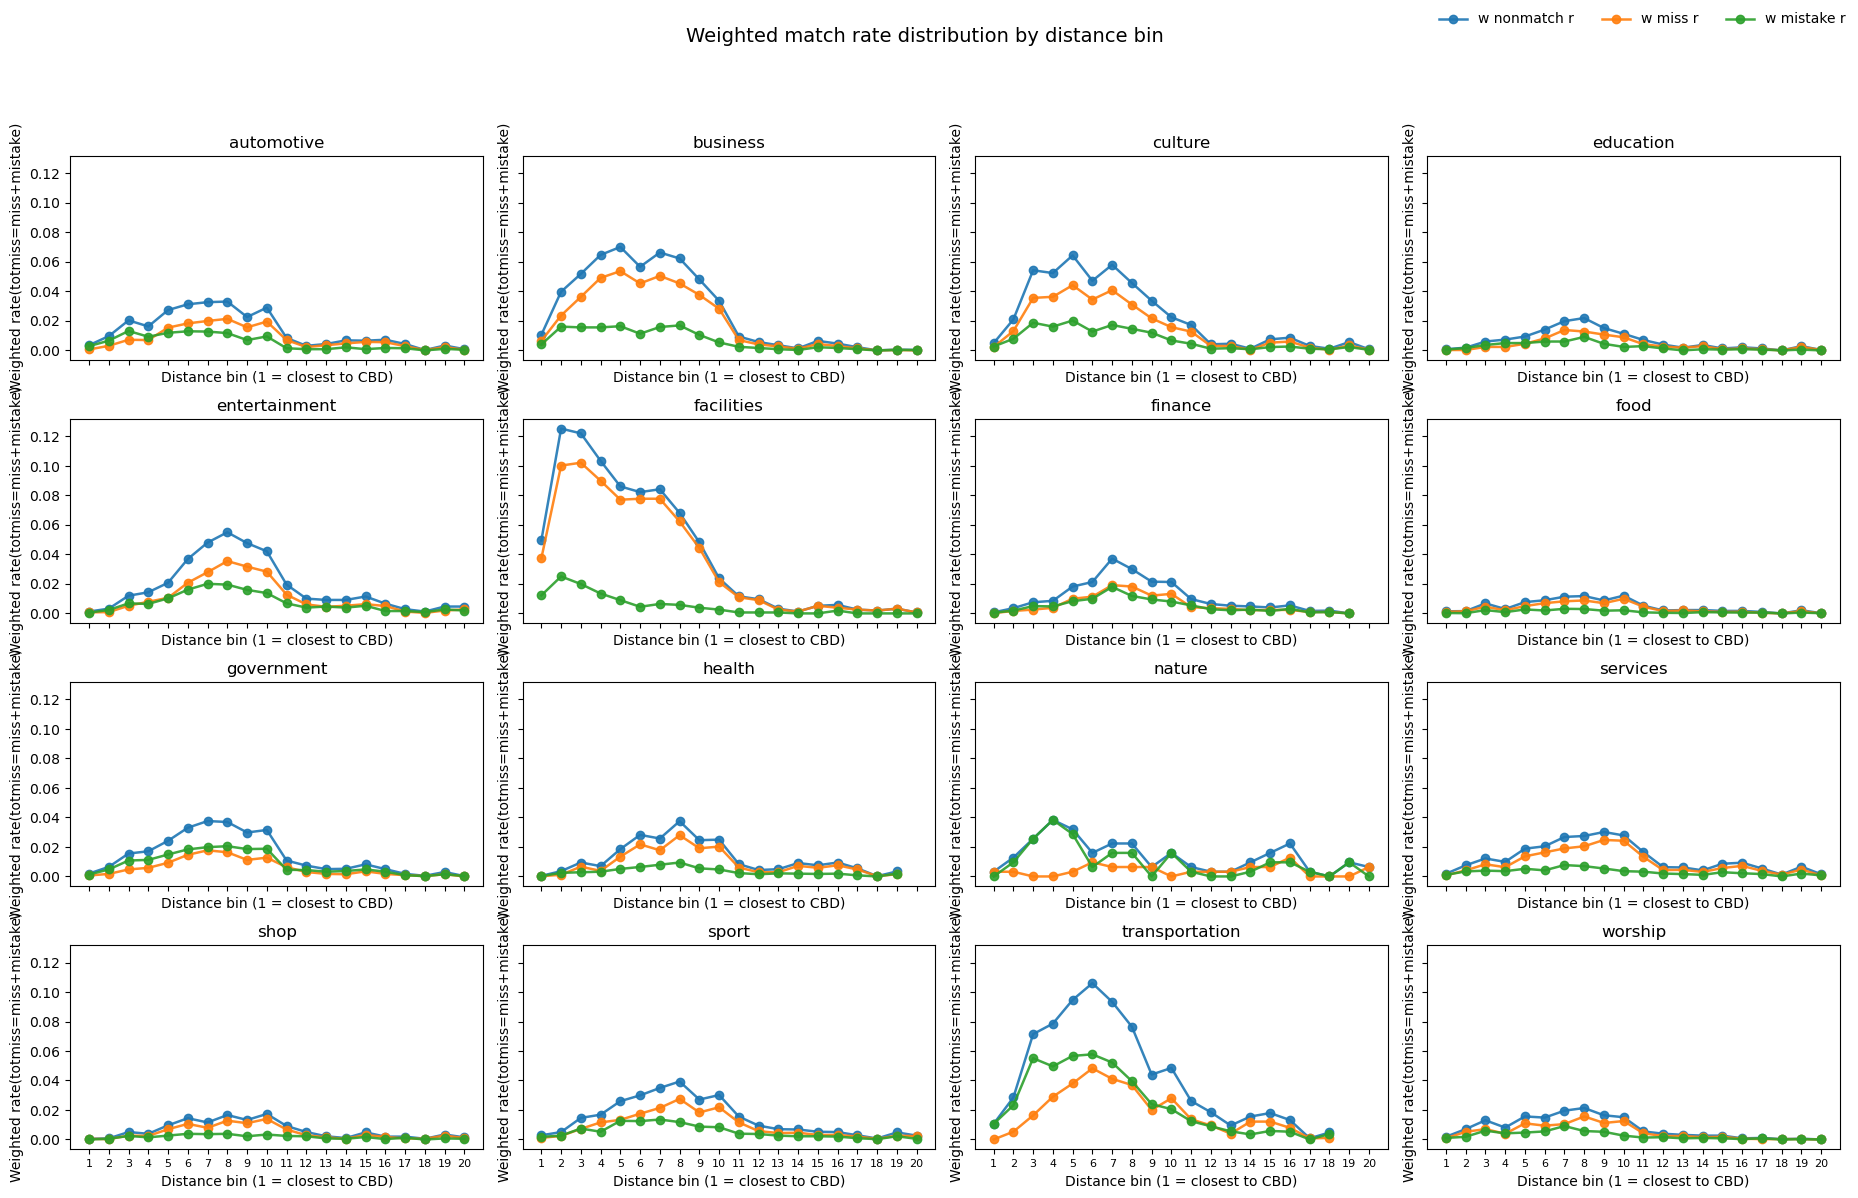

In [280]:
plot_missmate_by_dist(
    df_all_bins,
    dens_cols=("w_nonmatch_r","w_miss_r","w_mistake_r"),
    ylabel="Weighted rate(totmiss=miss+mistake)",
    title="Weighted match rate distribution by distance bin"
)

In [234]:
df_merge = summarize_category_match_rate(ny_gplc_ove)

In [242]:
df_merge

,primary_cat,ove_count,google_count,cat_per,ove_google_m
0,food,6408,7055,0.107415,0.908292
4,entertainment,3567,5580,0.084957,0.639247
1,services,4189,5574,0.084866,0.751525
2,health,4057,5287,0.080496,0.767354
5,automotive,3546,4863,0.074041,0.729180
7,government,3330,4631,0.070509,0.719067
9,sport,3267,4579,0.069717,0.713475
6,finance,3342,4225,0.064327,0.791006
3,shop,3643,4159,0.063322,0.875932
10,worship,3252,3840,0.058465,0.846875


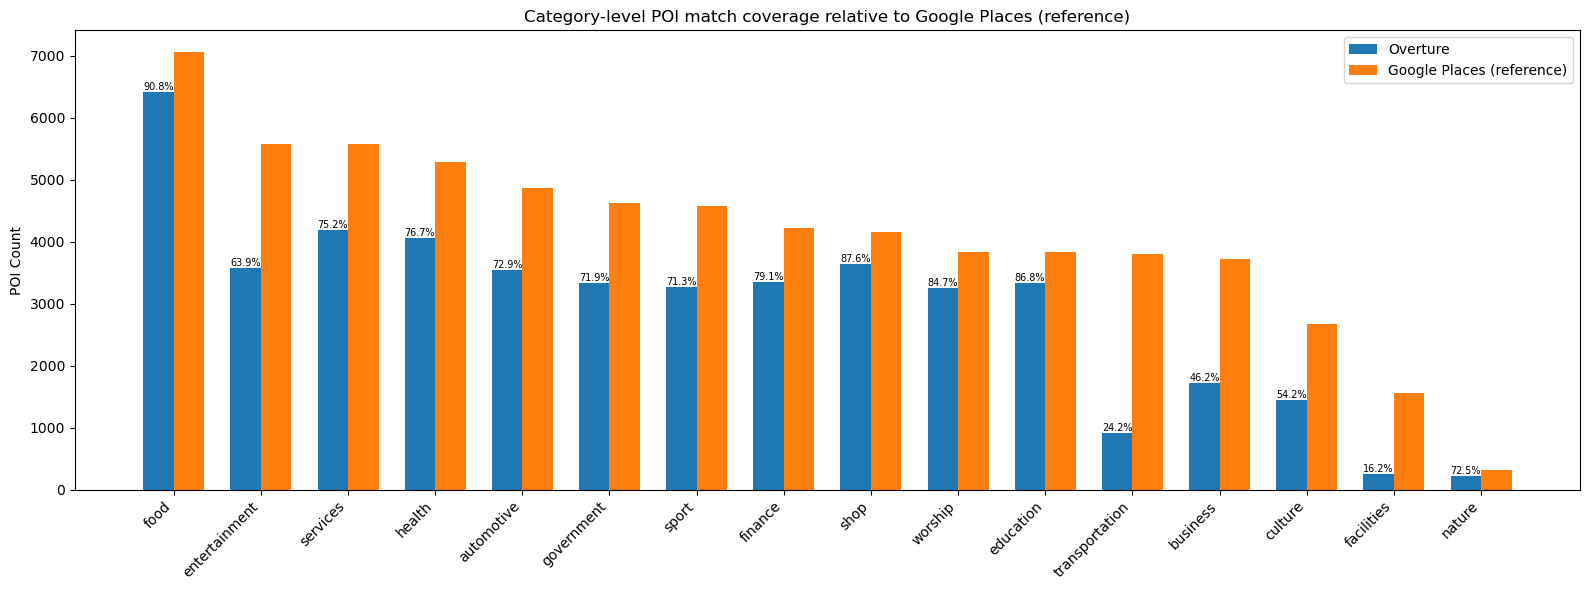

In [249]:
plot_category_coverage_bars(df_merge)

In [183]:
true_match_gplc_ove = ny_gplc_ove[(ny_gplc_ove['is_true_match'] == True) | (ny_gplc_ove['is_true_match'] == "1")]

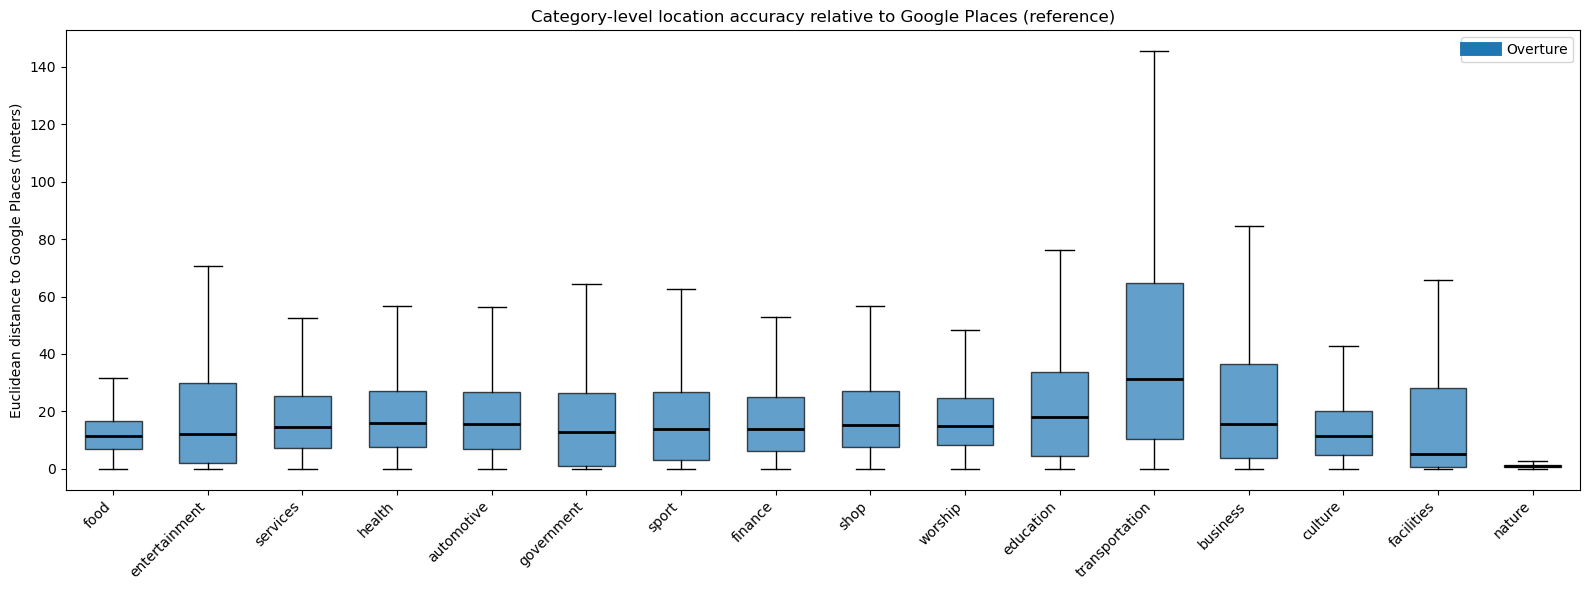

In [184]:
import numpy as np
import matplotlib.pyplot as plt

MAX_DIST = 1000
ove_vis = true_match_gplc_ove.query("location_distance <= @MAX_DIST")

# ① category 顺序：按 google_count
cat_order = df_merge.sort_values(
    'google_count', ascending=False
)['primary_cat'].tolist()

cats = [
    c for c in cat_order
    if c in ove_vis['primary_cat'].unique()
]

data_ove = []
cats_clean = []

for c in cats:
    vals = (
        ove_vis.loc[
            ove_vis.primary_cat == c,
            'location_distance'
        ]
        .dropna()
        .astype(float)
        .to_numpy()
    )

    if vals.size >= 1:
        data_ove.append(vals)
        cats_clean.append(c)

plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_ove,
    positions=np.arange(len(cats_clean)),
    widths=0.6,
    patch_artist=True,
    showfliers=False   # 不画极端异常值（可选）
)

for box in bp['boxes']:
    box.set_facecolor('#1f77b4')
    box.set_edgecolor('black')
    box.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

plt.xticks(
    np.arange(len(cats_clean)),
    cats_clean,
    rotation=45,
    ha='right'
)

plt.ylabel("Euclidean distance to Google Places (meters)")
plt.title("Category-level location accuracy relative to Google Places (reference)")

plt.legend(
    handles=[plt.Line2D([0], [0], color='#1f77b4', lw=10, label='Overture')],
    loc='upper right'
)

plt.tight_layout()
plt.show()


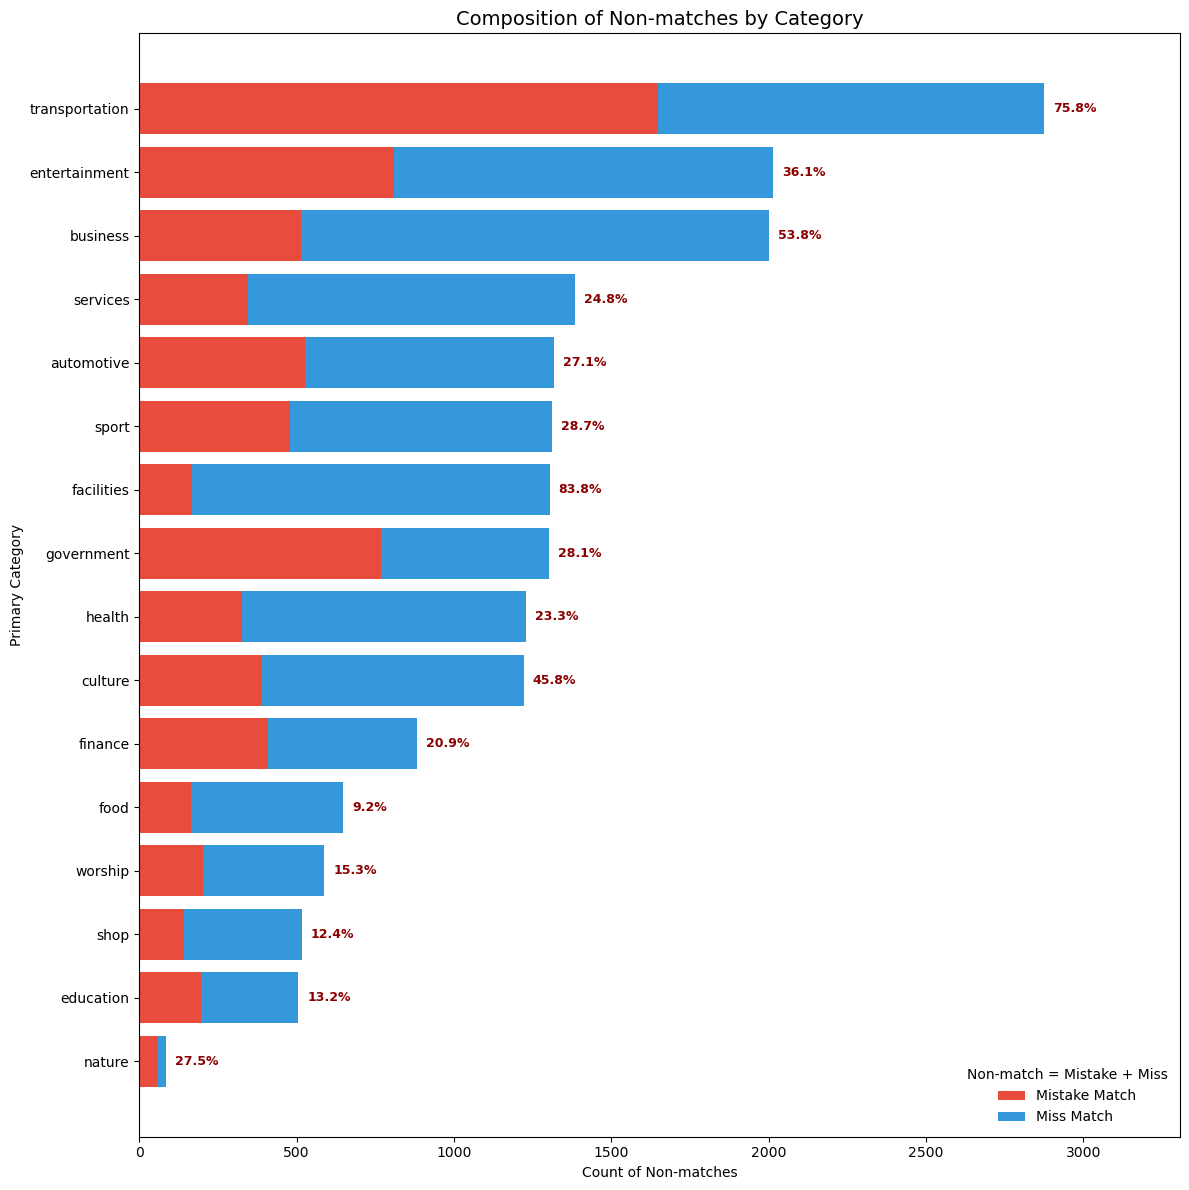

In [275]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_raw = ny_gplc_ove.copy()

df_raw['is_mistake'] = (df_raw["is_true_match"] == "0")
df_raw['is_miss'] = df_raw["is_true_match"].isna()

df_stats = df_raw.groupby("primary_cat").agg(
    n_mistake=('is_mistake', 'sum'),
    n_miss=('is_miss', 'sum'),
    total_count=('primary_cat', 'count')
).reset_index()

df_stats['total_non_match'] = df_stats['n_mistake'] + df_stats['n_miss']
df_stats['miss_rate_bysubcat'] = df_stats['total_non_match'] / df_stats['total_count']

TOP_N = 50 
plot_data = df_stats.nlargest(TOP_N, 'total_non_match').sort_values('total_non_match')

fig, ax = plt.subplots(figsize=(12, 12)) 

p1 = ax.barh(plot_data['primary_cat'], plot_data['n_mistake'], 
             color='#e74c3c', label='Mistake Match')

p2 = ax.barh(plot_data['primary_cat'], plot_data['n_miss'], 
             left=plot_data['n_mistake'], 
             color='#3498db', label='Miss Match')

for i, (idx, row) in enumerate(plot_data.iterrows()):
    total = row['total_non_match']
    rate = row['miss_rate_bysubcat']
    
    ax.text(total + (plot_data['total_non_match'].max() * 0.01), 
            i, 
            f'{rate:.1%}', 
            va='center', ha='left', fontsize=9, color='darkred', fontweight='bold')

ax.set_xlabel("Count of Non-matches")
ax.set_ylabel("Primary Category")
ax.set_title(f"Composition of Non-matches by Category", fontsize=14)
ax.legend(
    title=f"Non-match = Mistake + Miss", 
    title_fontsize=10,
    loc='lower right',
    frameon=False
)

ax.set_xlim(0, plot_data['total_non_match'].max() * 1.15)

plt.tight_layout()
plt.show()

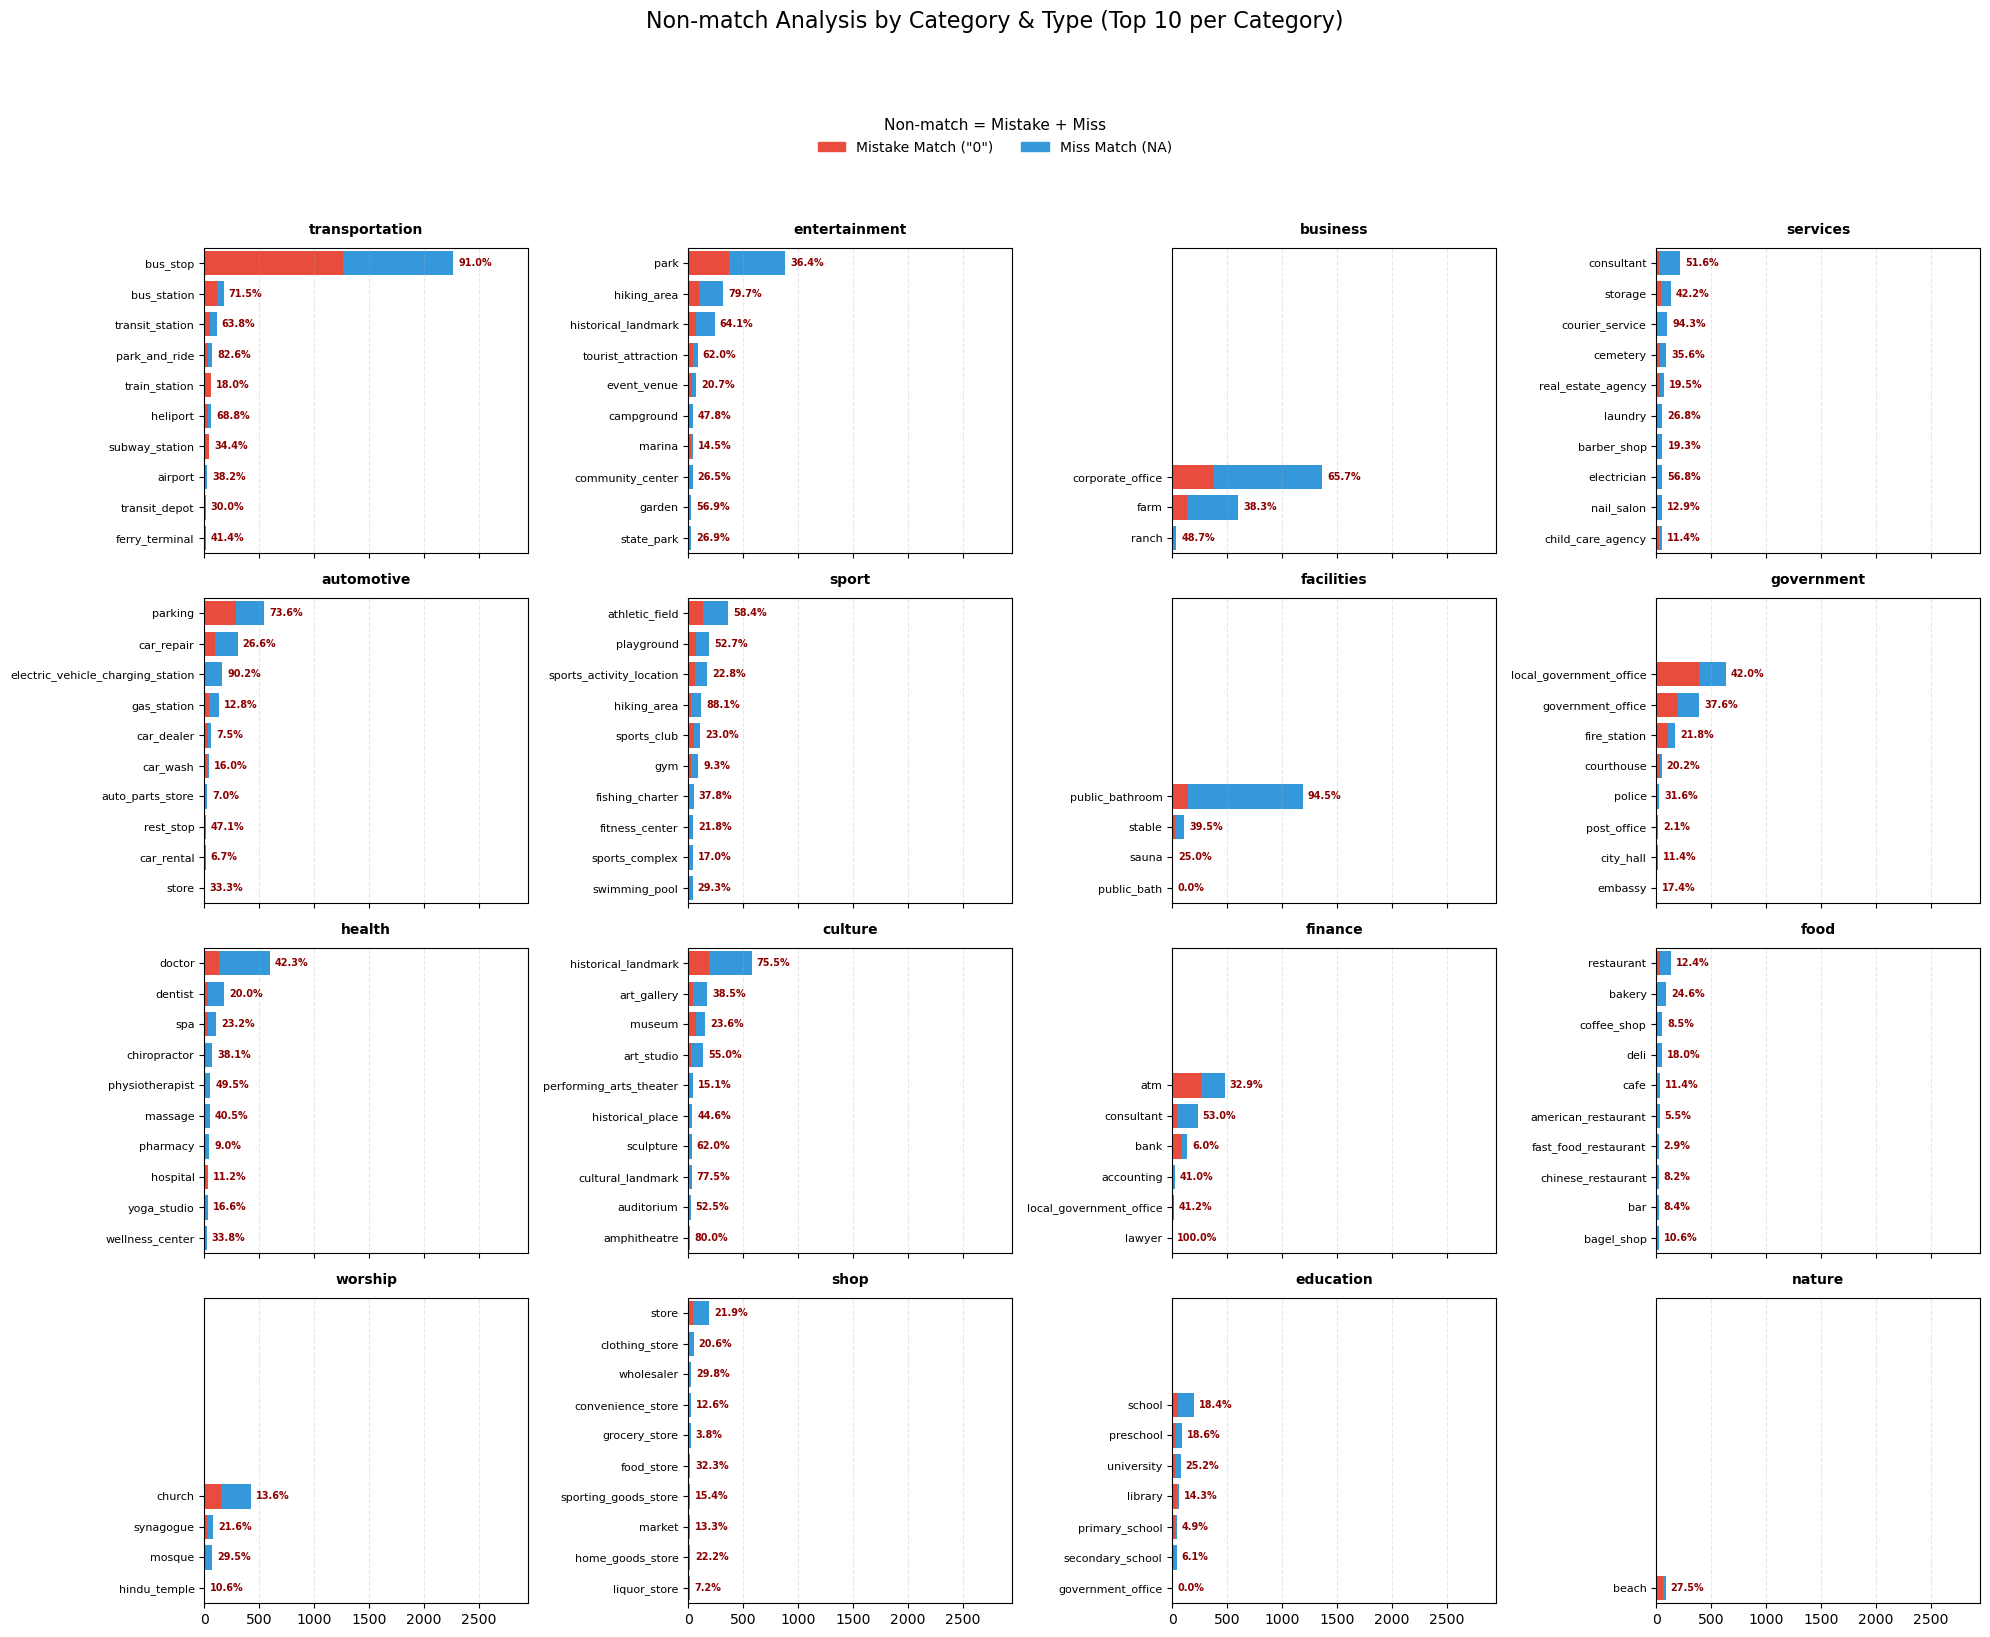

In [274]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 统计数据
df_raw = ny_gplc_ove.copy()
df_raw['is_mistake'] = (df_raw["is_true_match"] == "0")
df_raw['is_miss'] = df_raw["is_true_match"].isna()

df_all_stats = df_raw.groupby(["primary_cat", "primary_type"]).agg(
    n_mistake=('is_mistake', 'sum'),
    n_miss=('is_miss', 'sum'),
    total_count=('primary_cat', 'count')
).reset_index()

df_all_stats['total_non_match'] = df_all_stats['n_mistake'] + df_all_stats['n_miss']
df_all_stats['miss_rate'] = df_all_stats['total_non_match'] / df_all_stats['total_count']

# 2. 获取所有类别（不再限制为9个）
# 按照该大类的总错误量排序，方便查看
categories = df_all_stats.groupby("primary_cat")['total_non_match'].sum().sort_values(ascending=False).index.tolist()

# 3. 设置布局
n_cats = len(categories)
cols = 4  # 每行放4个子图，16个类刚好4行
rows = (n_cats + cols - 1) // cols
global_max_x = df_all_stats['total_non_match'].max()

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=True)
axes = axes.flatten()

# 4. 绘图
for i, cat in enumerate(categories):
    ax = axes[i]
    
    # 获取 Top 10
    plot_data = df_all_stats[df_all_stats['primary_cat'] == cat].nlargest(10, 'total_non_match').sort_values('total_non_match')
    
    # 核心修改：固定 Y 轴范围 (0 到 9.5)，确保即便只有1个细分类，柱子也不会变粗
    ax.set_ylim(-0.5, 9.5) 
    
    y_pos = np.arange(len(plot_data))
    
    ax.barh(y_pos, plot_data['n_mistake'], color='#e74c3c', label='Mistake' if i==0 else "")
    ax.barh(y_pos, plot_data['n_miss'], left=plot_data['n_mistake'], color='#3498db', label='Miss' if i==0 else "")
    
    # 设置细分类名称
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data['primary_type'], fontsize=8)
    
    # 标注比例
    for j, (idx, row) in enumerate(plot_data.iterrows()):
        ax.text(row['total_non_match'] + (global_max_x * 0.02), j, f"{row['miss_rate']:.1%}", 
                va='center', fontsize=7, color='darkred', fontweight='bold')
    
    ax.set_title(f"{cat}", fontsize=10, fontweight='bold', pad=10)
    ax.set_xlim(0, global_max_x * 1.3)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

# 移除多余的子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Non-match Analysis by Category & Type (Top 10 per Category)", fontsize=16, y=1.02)
plt.tight_layout()

# 1. 统一获取颜色句柄
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='#e74c3c', label='Mistake Match ("0")')
blue_patch = mpatches.Patch(color='#3498db', label='Miss Match (NA)')

# 2. 将 Legend 放在 Title 下方，图表上方
fig.legend(
    handles=[red_patch, blue_patch],
    title="Non-match = Mistake + Miss",
    title_fontsize=11,
    loc='upper center',          # 居中对齐
    bbox_to_anchor=(0.5, 0.96),   # 坐标 (x, y)，0.96 刚好在 Title (1.02) 下方
    ncol=2,                       # 并排显示，节省垂直空间
    frameon=False,                # 移除边框更简洁
    fontsize=10
)

# 3. 核心布局调整：rect=[左, 下, 右, 上]
# 这里将上边界 (top) 设置为 0.90，确保图表不会顶到 Legend
plt.tight_layout(rect=[0, 0, 1, 0.92]) 

plt.show()

In [289]:
transportation = ["bus_stop","bus_station","transit_station","park_and_ride","heliport"]
entertainment = ["hiking_area","historical_landmark","tourist_attraction"]
business = ["corporate_office"]
services = ["courier_service"]
automotive =["parking","electric_vehicle_charging_station"]
sport = ["athletic_field","hiking_area"]
facilities = ["public_bathroom"]
culture = ["historical_landmark","sculpture","cultural_landmark","amphitheatre"]
finance = ["lawyer"]

ignore_typelist = transportation + entertainment + business + services + automotive + sport + facilities + culture + finance

In [297]:
filterout = ny_gplc_ove[~ny_gplc_ove['primary_type'].isin(ignore_typelist)]
len(filterout[filterout['is_true_match']=="1"]) / len(filterout)

0.7964022306170174

In [300]:
sample_check = ny_gplc_ove[ny_gplc_ove['is_true_match'] != "1"]

In [315]:
df = ny_gplc_ove[ny_gplc_ove['is_true_match'] != "1"].copy()

N = 100

weights = df["primary_cat"].map(
    df["primary_cat"].value_counts(normalize=True)
)

df_sample = df.sample(
    n=N,
    weights=weights,
    random_state=42
)
df_sample[['id','name','addr_simple','naics_definition','matched_id','matched_name','matched_address','matched_cat_main','location_distance']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/df_sample_check.csv', index=False)
# df_sample[['id','name','addr_simple','naics_definition','matched_id','matched_name','matched_address','matched_cat_main','location_distance','geometry']].to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/df_sample_check.geojson')

In [341]:
mistake_match = ny_gplc_ove[ny_gplc_ove['is_true_match'] == '0'][['id','name','addr_simple','primary_type','matched_name','matched_address','matched_cat_main','location_distance']]
mistake_match

,id,name,addr_simple,primary_type,matched_name,matched_address,matched_cat_main,location_distance
3,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,5500-5598 S Long Beach Blvd,parking,Wooden Jetty,NaN,beach,122.987078
4,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,6805 S Long Beach Blvd,parking,Edwin B. Forsythe National Wildlife Refuge,11 Lincoln Ave,nature_reserve,312.705359
20,ChIJcckexlcCwYkR4IQBYcbbWzs,Tuckerton Self-Serve Car Wash,s 08087,car_wash,Captain Car Wash II,500 Route 9 S,car_wash,14.574829
72,ChIJTxzlh6OpwYkRMcoa5jIZZ_A,LBI Automotive LLC,242 W 9th St,car_repair,Sold On LBI,256 W 9th St,real_estate_agent,63.976992
78,ChIJO8aG6SIGwYkRctbiQRtgmZs,NJMVC Inspection Station,Cook Rd,car_repair,Manahawkin Inspection Station,220 Stafford Park Blvd,public_and_government_association,95.469548
...,...,...,...,...,...,...,...,...
65669,ChIJJ1zhQfg23YkR4ULlEDI5BHA,Dutchess Mall,Fishkill,bus_stop,Dutchess Mall,I-84,shopping_center,121.824276
65675,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,Fishkill,bus_stop,"Alan N. Berman, DPM",400 Westage Business Ctr Dr Ste 106,podiatrist,548.519604
65676,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,Unnamed Road,park_and_ride,Cancha KENT,22 Drew Rd,active_life,349.626578
65677,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,Patterson,train_station,PATTERSON,19 FRONT ST,post_office,118.431280


In [342]:
miss_match = ny_gplc_ove[ny_gplc_ove['is_true_match'].isna()][['id','name','addr_simple','primary_type','matched_name','matched_address','matched_cat_main']]
miss_match

,id,name,addr_simple,primary_type,matched_name,matched_address,matched_cat_main
1,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,167 S New York Rd,car_repair,NaN,NaN,NaN
5,ChIJuzW1jbT_wIkRrbmQMsZmavA,ChargePoint Charging Station,5500-5598 S Long Beach Blvd,electric_vehicle_charging_station,NaN,NaN,NaN
7,ChIJM9uKs3QdwYkRbU6aNEcLo3c,Delta,5695 US-9 N,gas_station,NaN,NaN,NaN
8,ChIJHWGLLjvPxokR3j8AkKJsi_o,Jz tire shop 2,5695 US-9,car_repair,NaN,NaN,NaN
9,ChIJoVx6RQQdwYkRC76Yj15n3Vw,JZ TIRE SHOP AND AUTO SERVICE,5695 US-9,car_repair,NaN,NaN,NaN
...,...,...,...,...,...,...,...
65671,ChIJMzZIEP423YkRCXd0NmIygjA,Westage Drive & Route 9 South,Fishkill,bus_stop,NaN,NaN,NaN
65672,ChIJIa84dwE33YkRS7cvEpZkvjk,Rt 9 S & W Merritt Blvd,Fishkill,bus_stop,NaN,NaN,NaN
65673,ChIJf6EDaAQ33YkRs9CAODJ2Evc,Route 9 N & Elm Street,Fishkill,bus_stop,NaN,NaN,NaN
65674,ChIJgRgTYQQ33YkROQWYtg0z9pk,Route 9 S & Elm Street,Fishkill,bus_stop,NaN,NaN,NaN


In [346]:
mistake_match[mistake_match['addr_simple'] == mistake_match['matched_address']]

,id,name,addr_simple,primary_type,matched_name,matched_address,matched_cat_main,location_distance
428,ChIJVXkOq1hewYkRGS9vzVqA2c8,Walmart Auto Care Center,700 Marketplace Blvd,car_repair,Auntie Anne's Pretzels Hamilton Walmart #2518,700 Marketplace Blvd,bakery,153.891659
434,ChIJX0ZZFw9hwYkR6I_-m1HpEDc,amazon west parking lot,50 New Canton Way,parking,Integrity Staffing Solutions Onsite at Amazon,50 New Canton Way,business,100.346102
577,ChIJw_EVrjHUw4kRH1b80gJ8GyQ,Electrify America Charging Station,3710 US-9,electric_vehicle_charging_station,Aerie,3710 US-9,clothing_store,459.963468
2279,ChIJX94RIXVJ6IkRtjNWktYZ7c0,Costco Gas Station,125 Beacon Dr,gas_station,Costco Wholesale,125 Beacon Dr,superstore,202.332024
3111,ChIJ7YujElv16IkRGEIdjdEbNt0,SS Auto Repair,1556 W Main St,car_repair,NAPA Auto Parts - My Guy Auto Supply,1556 W Main St,auto_parts_and_supply_store,97.415271
5780,ChIJFR6BuX0KxIkRhqNRpfecBCI,Beneduce Vineyards,1 Jeremiah Ln,farm,Beneduce Vineyards,1 Jeremiah Ln,winery,506.105706
6930,ChIJ89zxQyehw4kRFqBntQc4CrE,Greystone Park Greenhouse,59 Koch Ave,farm,Greystone Park Psychiatric Hospital,59 Koch Ave,hospital,187.683681
7038,ChIJ1Zk5s0n0wokRj7bymIK8tv8,Vivero Live Poultry Farm,1167 Webster Ave,ranch,Webster Live Chicken,1167 Webster Ave,butcher_shop,27.191851
7047,ChIJnVcpOI1ZwokRGBXiU1S70Ac,Lottery Division,317 Malcolm X Blvd,corporate_office,Temporary and Disability Division,317 Malcolm X Blvd,public_and_government_association,119.972199
7090,ChIJo5KeGqYp6IkRPM9zfqUyDSo,Affari Equestrian LLC,62 Hegemans Ln,farm,Nassau Gold Coast Equestrian Center/Large Anim...,62 Hegemans Ln,pet_services,77.043307


# Findings for Overture Maps with DOHMH of NYC

In [193]:
from shapely.geometry import Point
ts_p = Point(-73.98552115962701, 40.757986758482154)

nyc_c_ove = add_distance_bins_to_point(
    nyc_c_ove,
    ts_p,
    n_bins=20,
    src_crs="EPSG:4326",
    proj_crs="EPSG:3857",
    dist_col="dist_to_point",
    bin_col="dist_bin"
)

In [194]:
nyc_c_ove_all_bins = summarize_match_miss_by_dist_bin(
    nyc_c_ove,
    cat_col = "category",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_miss_col = "n_miss",
    n_match_col = "n_match",
    miss_c_col = "miss_c",
    match_c_col = "match_c",
    miss_density_col = "miss_den",
    match_density_col = "match_den",
    total_density_col = "total_den", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_23161/816419381.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, right_margin, 0.95])


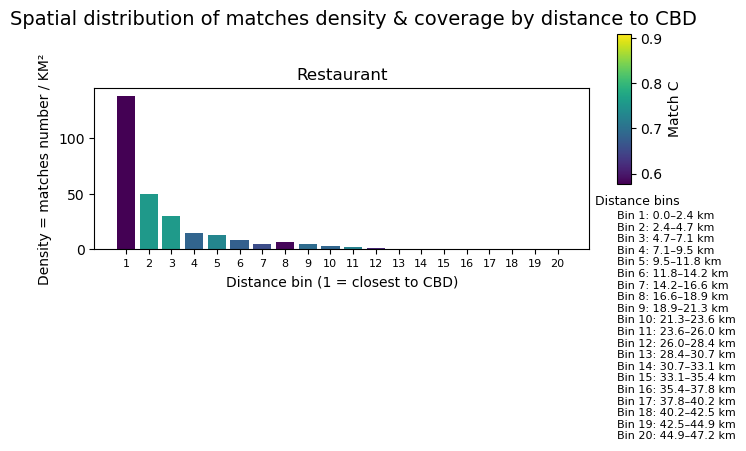

In [195]:
plot_dist_bin_bars(
    nyc_c_ove_all_bins,
    color_col="match_c",
    y = 'match_den',
    cmap=plt.cm.viridis,
    primary_cat_col="category",
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Density = matches number / KM²",
    title="Spatial distribution of matches density & coverage by distance to CBD",
    n_cols=1,
    xtick_fontsize=8,
)

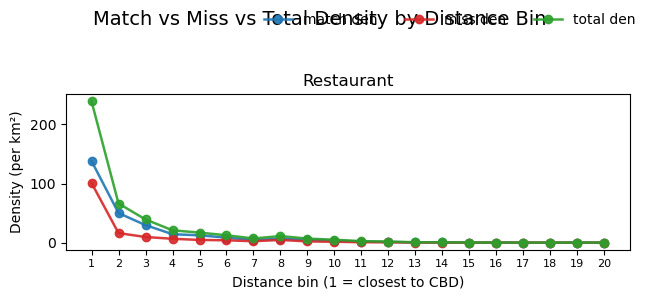

In [279]:
plot_density_compare_by_dist(
    nyc_c_ove_all_bins,
    dens_cols=("match_den", "miss_den", "total_den"),
    primary_cat_col="category",
    title="Match vs Miss vs Total Density by Distance Bin",
    n_cols=1,
)

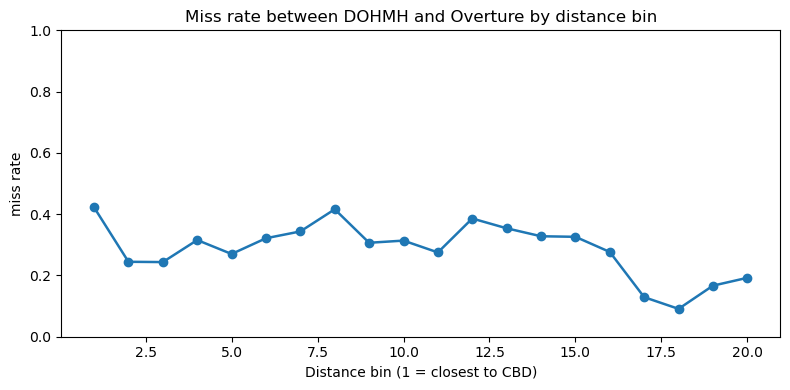

In [295]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    nyc_c_ove_all_bins["bin_id"],
    nyc_c_ove_all_bins["miss_c"],
    marker="o",
    linewidth=1.8
)

ax.set_xlabel("Distance bin (1 = closest to CBD)")
ax.set_ylabel("miss rate")
ax.set_title("Miss rate between DOHMH and Overture by distance bin")
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [203]:
nyc_c_ove_merge = summarize_category_match_rate(
    nyc_c_ove, 
    cat_col="category",
    ref_col = "dohmh_count",
    compare_col = "ove_count",
    cg_m_col = "ove_dohmh_m",
    )

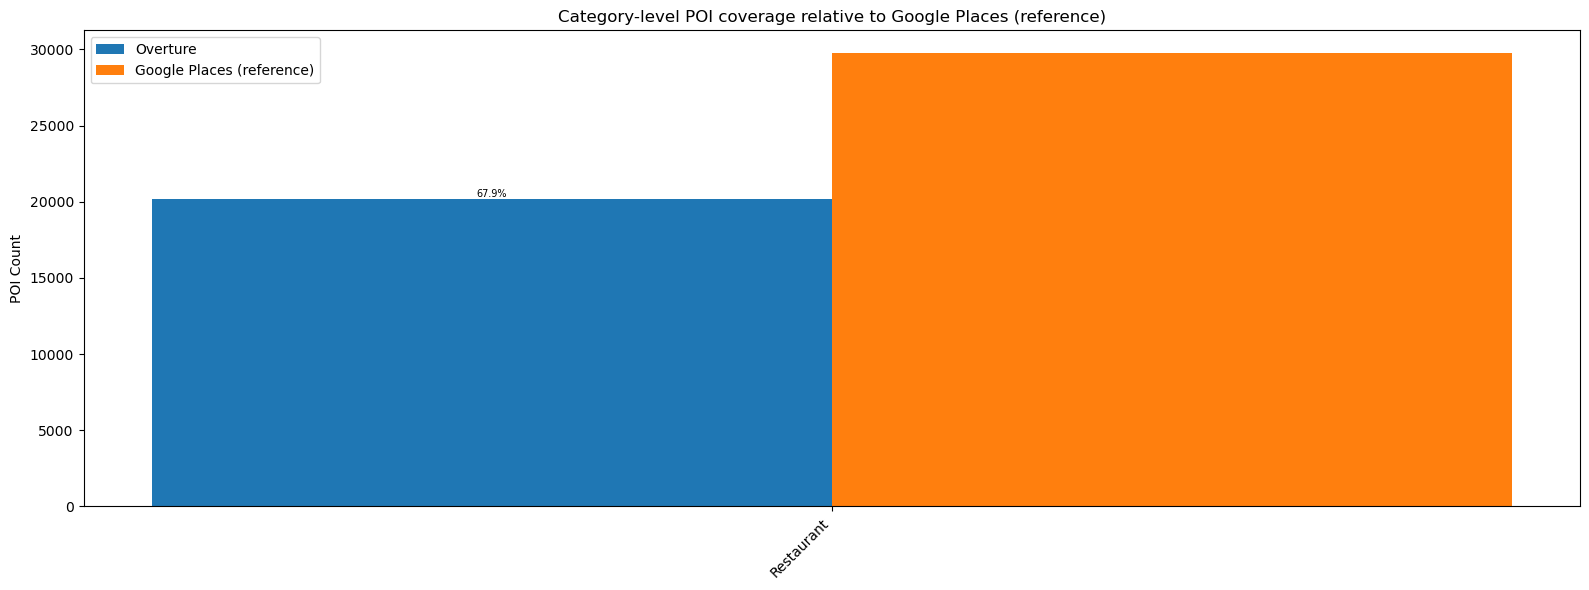

In [210]:
plot_category_coverage_bars(
    nyc_c_ove_merge,
    cat_col="category",
    compare_col="ove_count",
    ref_col="dohmh_count",
    ratio_col="ove_dohmh_m",
    width=0.35,
    figsize=(16, 6),
    ylabel="POI Count",
    title="Category-level POI coverage relative to Google Places (reference)",
    rotate_xticks=45,
    ratio_fmt="{:.1f}%",
    ratio_fontsize=7,
)

In [216]:
true_match_c_ove = nyc_c_ove[(nyc_c_ove['is_true_match'] == True) | (nyc_c_ove['is_true_match'] == "1")]
true_match_c_ove['location_distance'] = true_match_c_ove['location_distance'].astype(float)

/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [219]:
nyc_c_ove_merge

,category,ove_count,dohmh_count,g_cat_per,ove_dohmh_m
0,Restaurant,20204,29767,1.0,0.678738


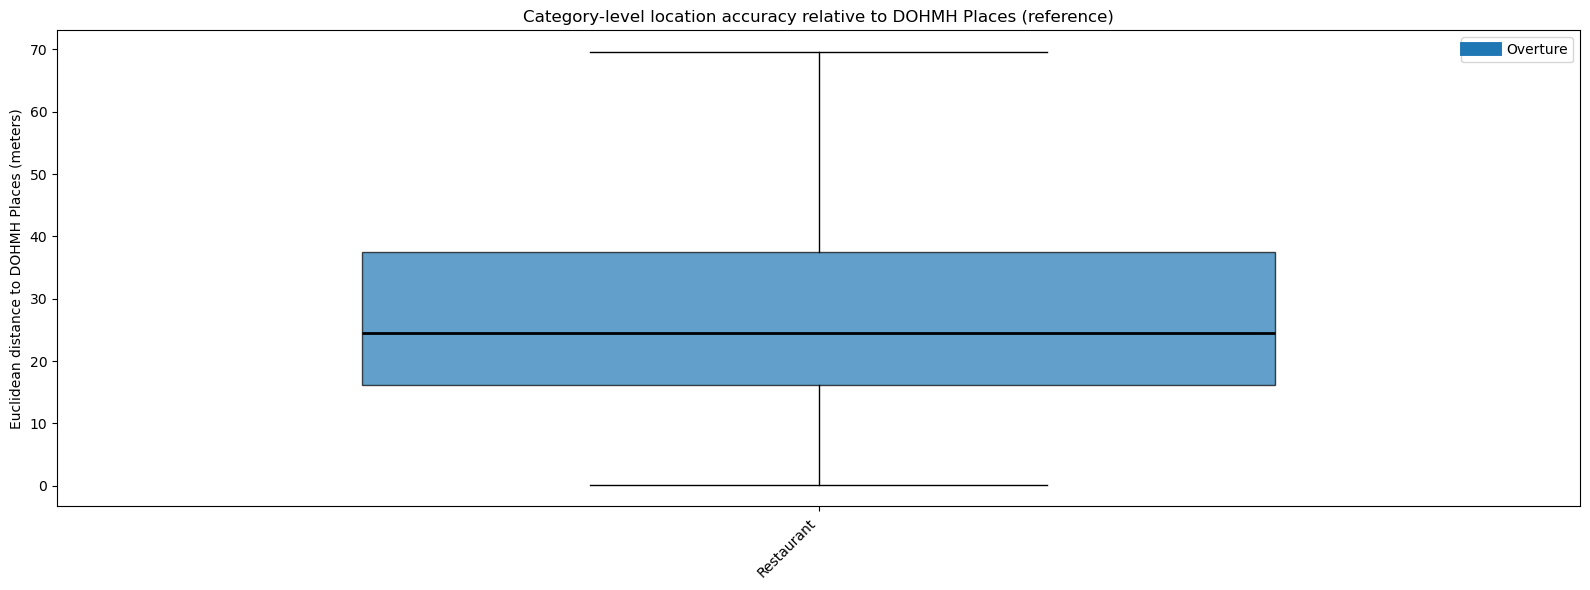

In [220]:
import numpy as np
import matplotlib.pyplot as plt

MAX_DIST = 100
ove_vis = true_match_c_ove.query("location_distance <= @MAX_DIST")

cat_order = nyc_c_ove_merge.sort_values(
    'dohmh_count', ascending=False
)['category'].tolist()

cats = [
    c for c in cat_order
    if c in ove_vis['category'].unique()
]

data_ove = []
cats_clean = []

for c in cats:
    vals = (
        ove_vis.loc[
            ove_vis.category == c,
            'location_distance'
        ]
        .dropna()
        .astype(float)
        .to_numpy()
    )

    if vals.size >= 1:
        data_ove.append(vals)
        cats_clean.append(c)

plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_ove,
    positions=np.arange(len(cats_clean)),
    widths=0.6,
    patch_artist=True,
    showfliers=False   # 不画极端异常值（可选）
)

for box in bp['boxes']:
    box.set_facecolor('#1f77b4')
    box.set_edgecolor('black')
    box.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

plt.xticks(
    np.arange(len(cats_clean)),
    cats_clean,
    rotation=45,
    ha='right'
)

plt.ylabel("Euclidean distance to DOHMH Places (meters)")
plt.title("Category-level location accuracy relative to DOHMH Places (reference)")

plt.legend(
    handles=[plt.Line2D([0], [0], color='#1f77b4', lw=10, label='Overture')],
    loc='upper right'
)

plt.tight_layout()
plt.show()


# Findings for DOHMH with Google places

In [266]:
len(ny_gplc_c[ny_gplc_c['is_true_match'] ==1])/ len(ny_gplc_c)

0.8376068376068376

In [222]:
from shapely.geometry import Point
ts_p = Point(-73.98552115962701, 40.757986758482154)

ny_gplc_c = add_distance_bins_to_point(
    ny_gplc_c,
    ts_p,
    n_bins=20,
    src_crs="EPSG:4326",
    proj_crs="EPSG:3857",
    dist_col="dist_to_point",
    bin_col="dist_bin"
)

In [231]:
ny_gplc_c_all_bins = summarize_match_miss_by_dist_bin(
    ny_gplc_c,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = 1,
    n_miss_col = "n_miss",
    n_match_col = "n_match",
    miss_c_col = "miss_c",
    match_c_col = "match_c",
    miss_density_col = "miss_den",
    match_density_col = "match_den",
    total_density_col = "total_den", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_23161/816419381.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, right_margin, 0.95])


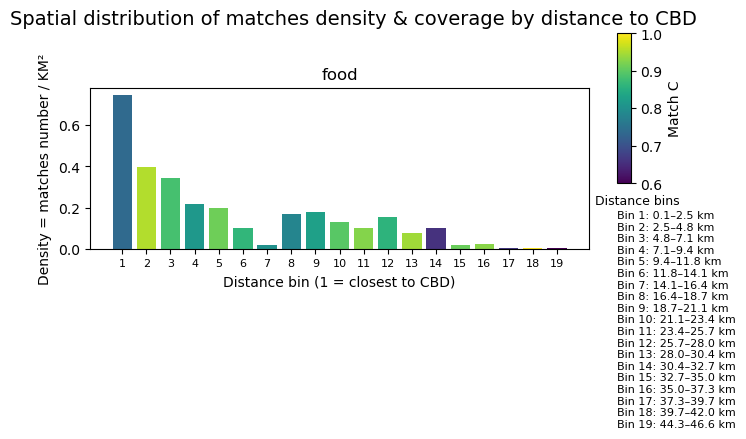

In [233]:
plot_dist_bin_bars(
    ny_gplc_c_all_bins,
    color_col="match_c",
    y = 'match_den',
    cmap=plt.cm.viridis,
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Density = matches number / KM²",
    title="Spatial distribution of matches density & coverage by distance to CBD",
    n_cols=1,
    xtick_fontsize=8,
)

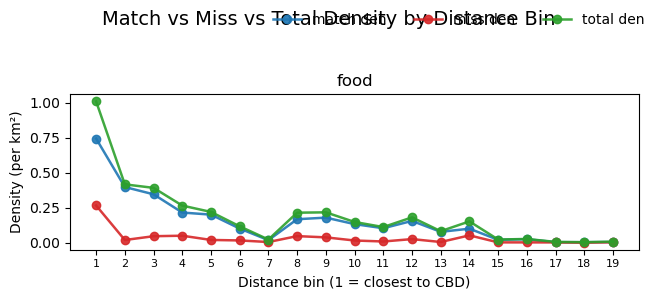

In [235]:
plot_density_compare_by_dist(
    ny_gplc_c_all_bins,
    dens_cols=("match_den", "miss_den", "total_den"),
    title="Match vs Miss vs Total Density by Distance Bin",
    n_cols=1,
)

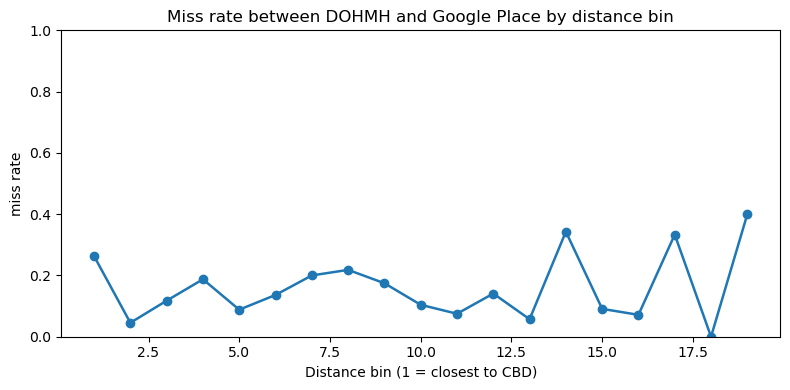

In [298]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    ny_gplc_c_all_bins["bin_id"],
    ny_gplc_c_all_bins["miss_c"],
    marker="o",
    linewidth=1.8
)

ax.set_xlabel("Distance bin (1 = closest to CBD)")
ax.set_ylabel("miss rate")
ax.set_title("Miss rate between DOHMH and Google Place by distance bin")
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [252]:
ny_gplc_c_merge = summarize_category_match_rate(
    ny_gplc_c, 
    cat_col="primary_cat",
    ref_col = "google_count",
    compare_col = "dohmh_count",
    cg_m_col = "dohmh_google_m",
    )

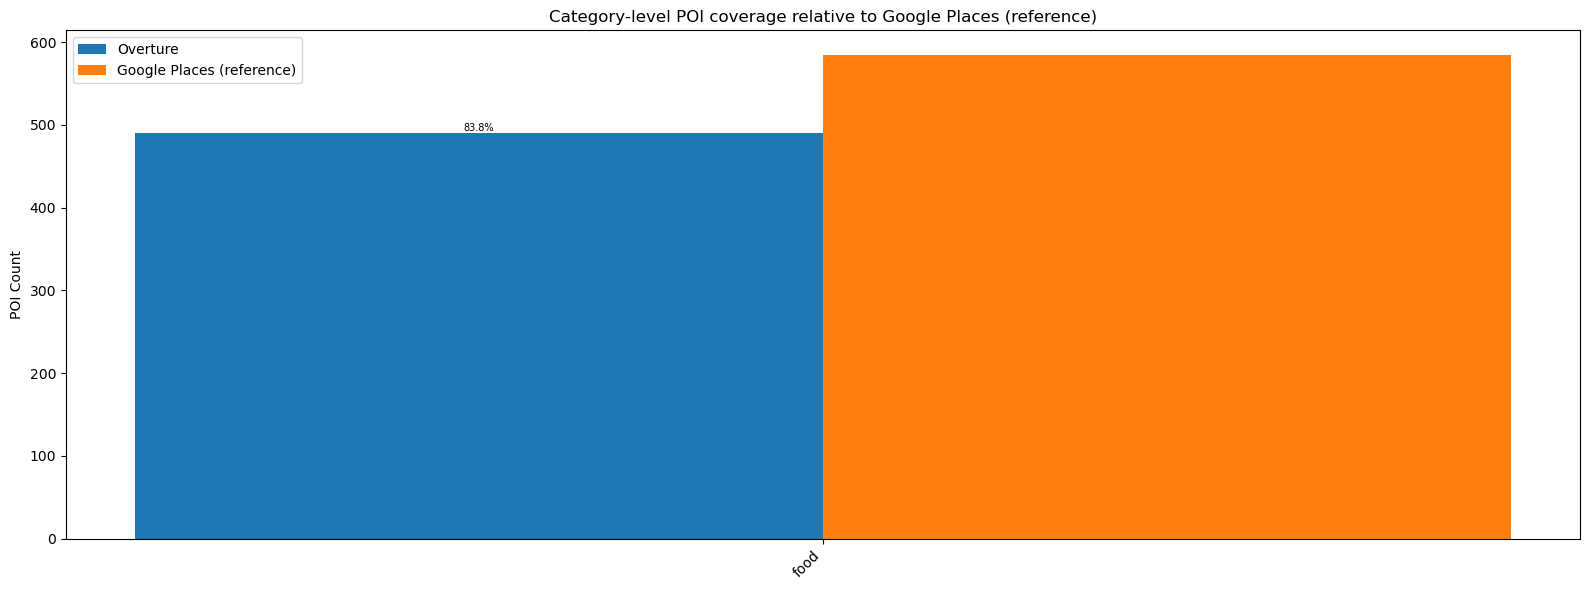

In [255]:
plot_category_coverage_bars(
    ny_gplc_c_merge,
    cat_col="primary_cat",
    compare_col="dohmh_count",
    ref_col="google_count",
    ratio_col="dohmh_google_m",
    width=0.35,
    figsize=(16, 6),
    ylabel="POI Count",
    title="Category-level POI coverage relative to Google Places (reference)",
    rotate_xticks=45,
    ratio_fmt="{:.1f}%",
    ratio_fontsize=7,
)

In [257]:
true_match_gplc_c = ny_gplc_c[(ny_gplc_c['is_true_match'] == True) | (ny_gplc_c['is_true_match'] == "1")]
true_match_gplc_c['location_distance'] = true_match_gplc_c['location_distance'].astype(float)

/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


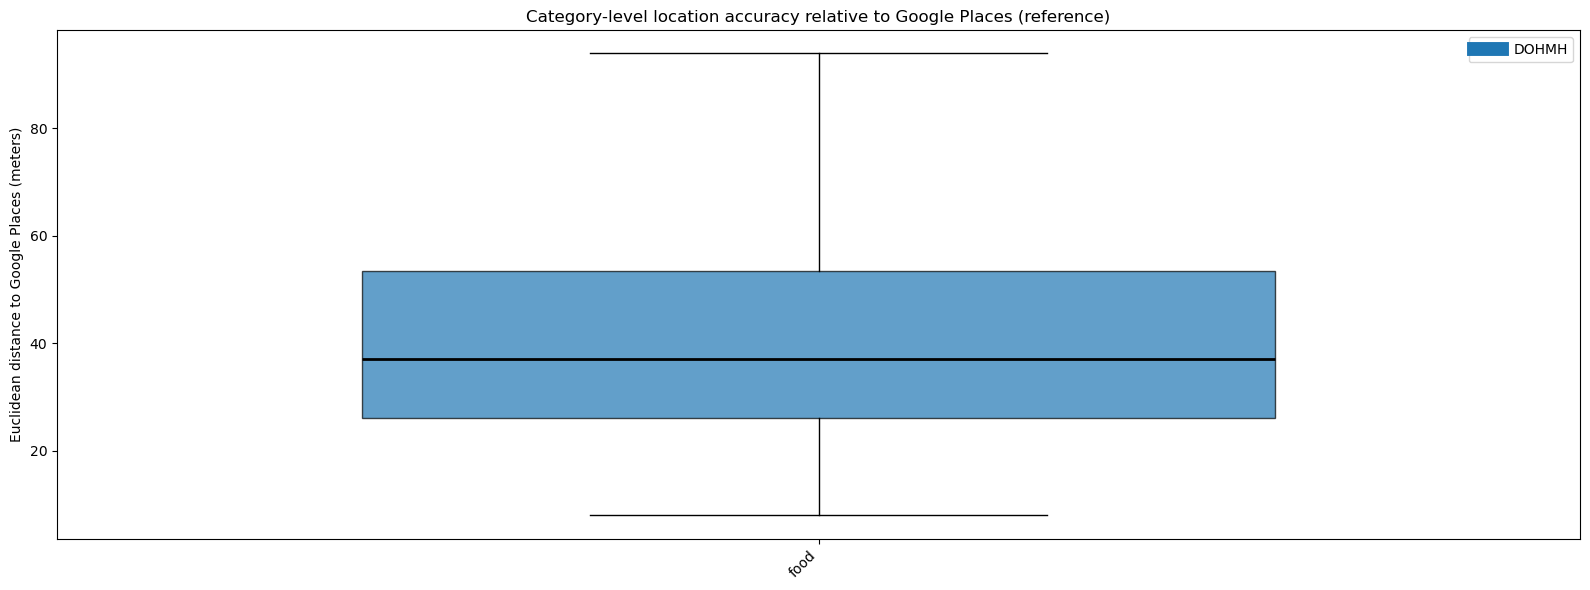

In [260]:
import numpy as np
import matplotlib.pyplot as plt

MAX_DIST = 100
ove_vis = true_match_gplc_c.query("location_distance <= @MAX_DIST")

# ① category 顺序：按 google_count
cat_order = ny_gplc_c_merge.sort_values(
    'google_count', ascending=False
)['primary_cat'].tolist()

cats = [
    c for c in cat_order
    if c in ove_vis['primary_cat'].unique()
]

data_ove = []
cats_clean = []

for c in cats:
    vals = (
        ove_vis.loc[
            ove_vis.primary_cat == c,
            'location_distance'
        ]
        .dropna()
        .astype(float)
        .to_numpy()
    )

    if vals.size >= 1:
        data_ove.append(vals)
        cats_clean.append(c)

plt.figure(figsize=(16, 6))

bp = plt.boxplot(
    data_ove,
    positions=np.arange(len(cats_clean)),
    widths=0.6,
    patch_artist=True,
    showfliers=False   # 不画极端异常值（可选）
)

for box in bp['boxes']:
    box.set_facecolor('#1f77b4')
    box.set_edgecolor('black')
    box.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

plt.xticks(
    np.arange(len(cats_clean)),
    cats_clean,
    rotation=45,
    ha='right'
)

plt.ylabel("Euclidean distance to Google Places (meters)")
plt.title("Category-level location accuracy relative to Google Places (reference)")

plt.legend(
    handles=[plt.Line2D([0], [0], color='#1f77b4', lw=10, label='DOHMH')],
    loc='upper right'
)

plt.tight_layout()
plt.show()


In [307]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')

In [311]:
ny_gplc_c = ny_gplc_c.merge(ny_gplc[['id','primary_type']], on='id', how='left')

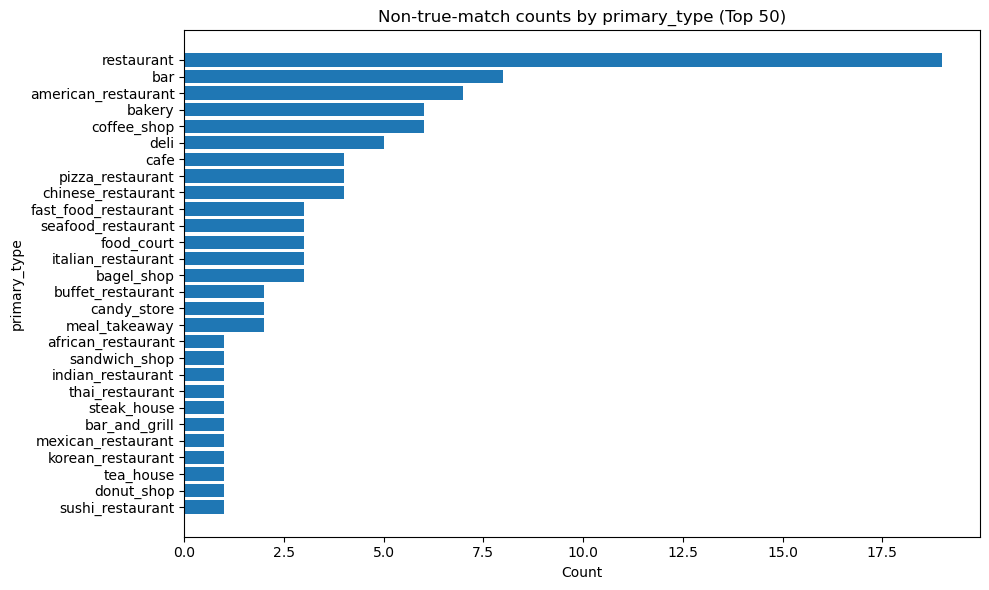

In [ ]:
import matplotlib.pyplot as plt

# 1) subset: not true match
miss = ny_gplc_c.loc[ny_gplc_c["is_true_match"] != 1, "primary_type"].dropna()

# 2) counts (top N to keep readable)
TOP_N = 50
counts = miss.value_counts().head(TOP_N).sort_values()  # sort for nicer horizontal bars

# 3) plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(counts.index.astype(str), counts.values)

ax.set_xlabel("Count")
ax.set_ylabel("primary_type")
ax.set_title(f"Non-true-match counts by primary_type (Top {TOP_N})")

plt.tight_layout()
plt.show()

In [348]:
df_miss = miss.value_counts()
df_miss = pd.DataFrame(df_miss).reset_index().rename(columns={'count':'total_miss'})

miss_list = miss.value_counts().index.tolist()
df_count = pd.DataFrame(ny_gplc_c[ny_gplc_c['primary_type'].isin(miss_list)]['primary_type'].value_counts()).reset_index().rename(columns={'count':'total_count'})

df_miss = df_miss.merge(df_count, on='primary_type', how='left')
df_miss['miss_rate_bysubcat'] = df_miss['total_miss'] / df_miss['total_count']

In [349]:
df_miss

,primary_type,total_miss,total_count,miss_rate_bysubcat
0,restaurant,19,93,0.204301
1,bar,8,45,0.177778
2,american_restaurant,7,43,0.162791
3,bakery,6,31,0.193548
4,coffee_shop,6,40,0.150000
5,deli,5,8,0.625000
6,cafe,4,19,0.210526
7,pizza_restaurant,4,23,0.173913
8,chinese_restaurant,4,28,0.142857
9,seafood_restaurant,3,15,0.200000


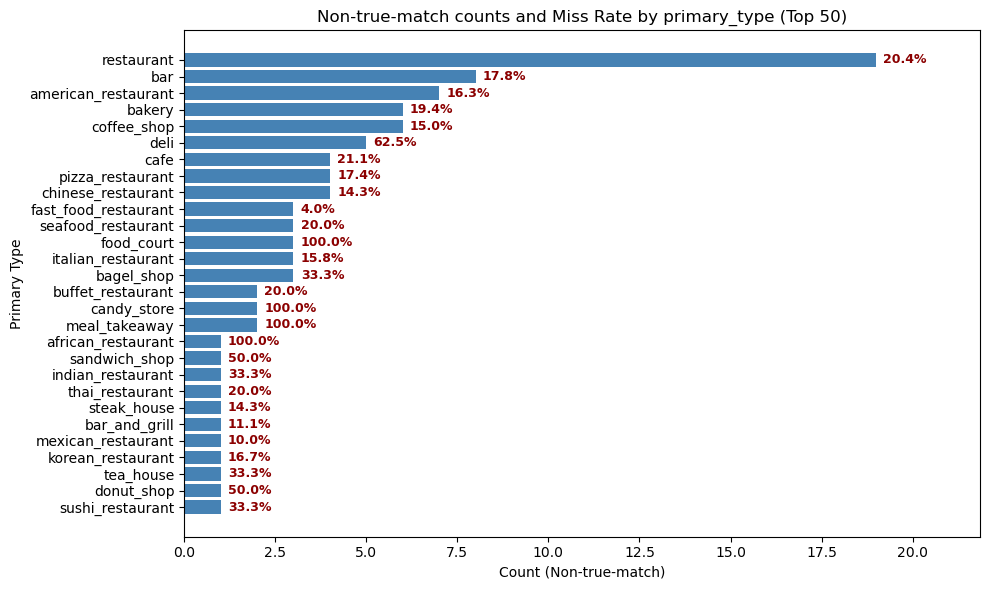

In [352]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 前置数据处理（基于你提供的逻辑） ---
# 1) 计算未匹配数
miss = ny_gplc_c.loc[ny_gplc_c["is_true_match"] != 1, "primary_type"].dropna()
df_miss = miss.value_counts().reset_index().rename(columns={'count':'total_miss'})

# 2) 计算总数并合并得到比例
miss_list = df_miss['primary_type'].tolist()
df_count = pd.DataFrame(ny_gplc_c[ny_gplc_c['primary_type'].isin(miss_list)]['primary_type'].value_counts()).reset_index().rename(columns={'count':'total_count'})

df_miss = df_miss.merge(df_count, on='primary_type', how='left')
df_miss['miss_rate_bysubcat'] = df_miss['total_miss'] / df_miss['total_count']

# --- 绘图部分 ---
TOP_N = 50
# 筛选出要画的 Top N 数据
plot_data = df_miss.head(TOP_N).sort_values('total_miss')

fig, ax = plt.subplots(figsize=(10, 6)) # 适当增加高度以容纳更多标签

# 绘制横向条形图
bars = ax.barh(plot_data['primary_type'], plot_data['total_miss'], color='steelblue')

# 在每个条形图右侧标记比例
for bar, rate in zip(bars, plot_data['miss_rate_bysubcat']):
    width = bar.get_width()
    # 在条形末端右侧 0.2 个单位处标注百分比
    ax.text(width + 0.2,                # x坐标
            bar.get_y() + bar.get_height()/2, # y坐标（条形中间）
            f'{rate:.1%}',             # 格式化为百分比，保留一位小数
            va='center',               # 垂直居中
            ha='left',                 # 水平靠左对齐
            fontsize=9,                # 字体大小
            color='darkred',           # 颜色区分
            fontweight='bold')         # 加粗

ax.set_xlabel("Count (Non-true-match)")
ax.set_ylabel("Primary Type")
ax.set_title(f"Non-true-match counts and Miss Rate by primary_type (Top {TOP_N})")

# 为了给右侧标签留出空间，增加 x 轴上限
ax.set_xlim(0, plot_data['total_miss'].max() * 1.15)

plt.tight_layout()
plt.show()

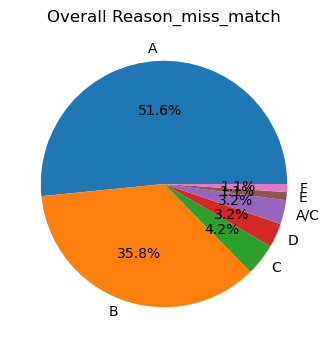

In [ ]:
import matplotlib.pyplot as plt

overall = ny_gplc_c_miss['Reason_miss_match'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(overall, labels=overall.index, autopct='%1.1f%%')
plt.title("Overall Reason_miss_match")
plt.show()

#### combine with partial_ratio 

In [523]:
from difflib import SequenceMatcher

def longest_common_substring(a, b):
    match = SequenceMatcher(None, a, b).find_longest_match(0, len(a), 0, len(b))
    return a[match.a: match.a + match.size]

s1 = "BORA BORA SMOOTHIE CAFE - BRIGHTON BEACH"
s2 = "BORA BORA SMOOTHIE CAFE/ SHEEL & MASHI"

print(longest_common_substring(s1, s2))

core = longest_common_substring(s1, s2)
LCS_coverage = len(core) / min(len(s1), len(s2))
print(LCS_coverage)

BORA BORA SMOOTHIE CAFE
0.6052631578947368


# Test for new match methodology

In [42]:
### read_dohmh_file
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DOHMH_New_York_City_Restaurant_Inspection_Results_20251227.geojson')
dohmh_res = dohmh_res.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at','dba':'name'})
dohmh_res['updated_year'] = pd.to_datetime(dohmh_res['updated_at']).dt.year
dohmh_res["address"] = (dohmh_res["building"].astype(str) + " " + dohmh_res["street"])
# dohmh_res = dohmh_res[['id','version','name','address','updated_year','geometry']]
dohmh_res['category'] = 'Restaurant'
dohmh_res=  dohmh_res.dropna(subset=['geometry']).reset_index(drop=True)
dohmh_res = dohmh_res.drop_duplicates(subset=['name','address','updated_year','geometry']).reset_index(drop=True)
dohmh_res

,id,version,created_at,updated_at,camis,name,boro,building,street,zipcode,...,bbl,nta,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_sbqj_enih,:@computed_region_92fq_4b7q,geometry,updated_year,address,category
0,row-3rda.zmw6_xp4m,rv-pdr7_f9vf.8tba,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50153196,KETEA,Queens,36-12,MAIN STREET,11354,...,4049710041,QN22,22,3,67,3,POINT (-73.83171 40.76252),2025,36-12 MAIN STREET,Restaurant
1,row-ytqa~g2vr.6a5z,rv-59qb.f9a2_ueuj,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50169800,APPLE BLOSSOM,Queens,40-05,SKILLMAN AVENUE,11104,...,4001830292,QN31,53,3,66,33,POINT (-73.92342 40.74720),2025,40-05 SKILLMAN AVENUE,Restaurant
2,row-rx7s_2p9t-iqp4,rv-tek2-4v6w_zjc6,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50176849,THE BLUE BLOSSOM,Brooklyn,135,NORTH 5 STREET,11249,...,3023350029,BK73,36,2,57,38,POINT (-73.95925 40.71694),2025,135 NORTH 5 STREET,Restaurant
3,row-bjv9.8q5f~gtur,rv-naqd~wgdf.tvjs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50180060,GREENLAND DELI PLUS CORP,Bronx,4311,KATONAH AVENUE,10470,...,2033780057,BX62,29,5,30,40,POINT (-73.86747 40.89905),2025,4311 KATONAH AVENUE,Restaurant
4,row-fn6x.ecsd-rr8d,rv-r2u5-2k5n.i3cs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50177809,FERMENTO,Manhattan,226,VARICK STREET,10014,...,1005280056,MN23,57,4,3,10,POINT (-74.00523 40.72913),2025,226 VARICK STREET,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29762,row-ym4t.mqkm.3x6i,rv-zbkb_xwgn-qq6y,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50177902,ARTHOUSE,Brooklyn,2717,AVENUE U,11229,...,3073320048,BK44,32,2,36,8,POINT (-73.94450 40.60014),2025,2717 AVENUE U,Restaurant
29763,row-aqni_a5n2.jh4z,rv-qhys.eupn-mnyz,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50177834,RAMEN BY RA,Manhattan,70,EAST 1 STREET,10003,...,1004430040,MN22,70,4,5,50,POINT (-73.98877 40.72341),2025,70 EAST 1 STREET,Restaurant
29764,row-4tez.e9t5~h2pz,rv-ntr4-wi27_6rec,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50172734,EARTHBAR,Manhattan,69,PRINCE STREET,10012,...,1005110001,MN24,57,4,2,32,POINT (-73.99707 40.72393),2025,69 PRINCE STREET,Restaurant
29765,row-n9j7-7v3f~i36m,rv-hd2r.v9w7~64zn,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50163793,ERNST & YOUNG - 8TH FLOOR,Manhattan,1,MANHATTAN WEST,10001,...,1007297504,MN13,12,4,6,10,POINT (-73.99713 40.75226),2025,1 MANHATTAN WEST,Restaurant


In [43]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')
ny_gplc['addr_simple'] = ny_gplc['address'].str.split(',', n=1).str[0]

nyc_ct = gpd.read_file('/Users/houpuli/Downloads/NYC_Borough_Boundary_5648926780594355063.geojson')
nyc_ct_geom = nyc_ct.dissolve()
nyc_ct_geom = nyc_ct_geom[['geometry']]

nyc_gplc = ny_gplc.sjoin(nyc_ct_geom, how='inner', predicate='intersects').drop(columns=['index_right'])
nyc_gplc_food = nyc_gplc[nyc_gplc['primary_cat']=='food']
nyc_gplc_food

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,addr_simple
27474,108,ChIJKa9zTFtKwokRU2HJ12JnXBs,Belli Baci Bakery.,"7358 Amboy Rd, Staten Island, NY 10307, USA",bakery,40.510533,-74.242272,food,POINT (-74.24227 40.51053),7358 Amboy Rd
27476,108,ChIJl8GODJzKw4kRIa6MfpzFw8A,Cracker Barrel Deli,"180 Main St, Staten Island, NY 10307, USA",deli,40.510567,-74.248541,food,POINT (-74.24854 40.51057),180 Main St
27618,123,ChIJOyOxW1m1w4kRX135VQ1AeMQ,McDonald's,"260 Page Ave, Staten Island, NY 10307, USA",fast_food_restaurant,40.517736,-74.234752,food,POINT (-74.23475 40.51774),260 Page Ave
27626,124,ChIJM5bI6WhJwokRj9GNkxvXnYs,Paris Baguette,"2742 Hylan Blvd, Staten Island, NY 10306, USA",bakery,40.564579,-74.113905,food,POINT (-74.11391 40.56458),2742 Hylan Blvd
27627,124,ChIJAU-quKBLwokRkSe_AEI9SV8,McDonald's,"3267 Richmond Ave, Staten Island, NY 10312, USA",fast_food_restaurant,40.559647,-74.168193,food,POINT (-74.16819 40.55965),3267 Richmond Ave
...,...,...,...,...,...,...,...,...,...,...
32521,253,ChIJ1RfMugf0wokR9plYzcTb04Y,Republica Restaurant Rooftop & Lounge,"160 Dyckman St, New York, NY 10040, USA",restaurant,40.863628,-73.926338,food,POINT (-73.92634 40.86363),160 Dyckman St
32524,254,ChIJAQAQfEnzwokR5cXlw6wWYxU,Code Red Restaurant & Lounge,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",restaurant,40.871194,-73.848109,food,POINT (-73.84811 40.87119),1320 E Gun Hill Rd
32525,254,ChIJ4bqLakONwokRgverxD9jjE8,KPOT Korean BBQ & Hot Pot,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",korean_restaurant,40.864270,-73.828121,food,POINT (-73.82812 40.86427),200 Baychester Ave 207A (2nd Floor
32527,254,ChIJw6EmV7qMwokRqwG2xMcSOpM,Olive Garden Italian Restaurant,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",italian_restaurant,40.864432,-73.827730,food,POINT (-73.82773 40.86443),200 Baychester Ave Suite 208A


In [44]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree

def search_spatial_candidates(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    k: int = 100,
    max_dist: float = 1000, 
    id_col: str = "id",
    crs_for_distance: int = 3857,
):
    """
    Attach k nearest compared POI ids & distances to reference_gdf.

    Returns
    -------
    GeoDataFrame with two new columns:
    - cand_ids   : list of compared ids
    - cand_dist_m: list of distances (meters)
    """

    ref_proj = reference_gdf.to_crs(crs_for_distance)
    cmp_proj = compared_gdf.to_crs(crs_for_distance)

    ref_xy = np.column_stack([ref_proj.geometry.x, ref_proj.geometry.y])
    cmp_xy = np.column_stack([cmp_proj.geometry.x, cmp_proj.geometry.y])

    tree = cKDTree(cmp_xy)
    k_eff = min(k, len(compared_gdf))

    dist, idx = tree.query(ref_xy, k=k_eff)

    if k_eff == 1:
        dist = dist.reshape(-1, 1)
        idx = idx.reshape(-1, 1)

    cmp_ids = compared_gdf[id_col].to_numpy()

    cand_ids = []
    cand_dists = []

    for row_idx, row_dist in zip(idx, dist):
        ids = []
        dists = []

        for j, d in zip(row_idx, row_dist):
            if d <= max_dist:
                ids.append(cmp_ids[j])
                dists.append(d)

        cand_ids.append(ids)
        cand_dists.append(dists)

    result = reference_gdf.copy()
    result["cand_ids"] = cand_ids
    result["cand_dist_m"] = cand_dists

    return result

In [45]:
FOOD_WORDS = {
    "RESTAURANT","RESTURANT","RESTARAUNT",
    "CAFE","CAFÉ","COFFEE","BAR","BISTRO","GRILL",
    "KITCHEN","DINER","EATERY","STEAKHOUSE",
    "SEAFOOD","BUFFET","BBQ","PIZZA","SUSHI","RAMEN",
    "NOODLE","NOODLES","BURGER","BURGERS","TACO","TACOS",
    "CHICKEN","WINGS","BAKERY","DELI","DELICATESSEN",
    "COURT","FOOD","EXPRESS","HOUSE","SHOP"
}

PLACE_WORDS = {
    "HALL","CENTER","CENTRE","PLAZA","MARKET","MALL",
    "GARDEN","GARDENS","PARK","SQUARE","TOWER","TOWERS",
    "STATION","TERMINAL","BUILDING","GALLERY","THEATER","SCHOOL","COURT","INN",
    "HOTEL","MOTEL","INN","SUITES","SUITE",
    "SPA","SALON","STUDIO","CENTER","CENTRE",
    "CLUB","LOUNGE","STATION","STOP"
}

LEGAL_WORDS = {
    "LLC","INC","CORP","CORPORATION","CO","COMPANY",
    "LTD","LIMITED","GROUP","HOLDINGS","OFFICE"
}

GRAMMAR = {
    "THE","OF","AT","AND","FOR","IN","ON","BY","WITH","TO","FROM"
}

NON_PRIMARY_TOKENS = FOOD_WORDS | PLACE_WORDS | LEGAL_WORDS | GRAMMAR

In [88]:
from rapidfuzz import process, fuzz
import pandas as pd
import re
import unicodedata


def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = re.sub(r"\b'S\b", "", s) # new change
    s = re.sub(r"\bS\b", "", s) # new change
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def extract_prinmary_str(name):

    tokens = name.split()
    core = [t for t in tokens if t not in NON_PRIMARY_TOKENS]
    if len(core) == 1 and len(core[0]) < 3:
        return name
    if core:
        return " ".join(core)
    return name

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    comp_name_col: str = "name",
    id_col: str = "id",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    # clean names for matching
    id_to_name_clean = compared_gdf.set_index(id_col)[comp_name_col].apply(clean_name).apply(extract_prinmary_str).to_dict()
    # raw names for storage
    id_to_name_raw = compared_gdf.set_index(id_col)[comp_name_col].to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []

    for _, row in reference_gdf.iterrows():
        query = extract_prinmary_str(clean_name(row.get(re_name_col)))

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            continue

        cand_names = [id_to_name_clean.get(cid, "") for cid in row["cand_ids"]]

        top_matches = process.extract(
            query,
            cand_names,
            scorer=fuzz.WRatio,
            limit=5
        )

        best_score = -1
        best_pos = None

        for name, wr, pos in top_matches:

            pr = fuzz.partial_ratio(query, name)
            ts = fuzz.token_sort_ratio(query, name)
            tset = fuzz.token_set_ratio(query, name)

            combined = max(wr, pr, ts, tset)

            if combined > best_score:
                best_score = combined
                best_pos = pos

        score = best_score

        if score >= threshold:
            matched_ids.append(row["cand_ids"][best_pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][best_pos])
            matched_names.append(id_to_name_raw.get(row["cand_ids"][best_pos]))
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)

    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names

    return result

In [46]:
from rapidfuzz import process, fuzz
import pandas as pd
import re
import unicodedata


def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = re.sub(r"\b'S\b", "", s) # new change
    s = re.sub(r"\bS\b", "", s) # new change
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def extract_prinmary_str(name):

    tokens = name.split()
    core = [t for t in tokens if t not in NON_PRIMARY_TOKENS]
    if len(core) == 1 and len(core[0]) < 3:
        return name
    if core:
        return " ".join(core)
    return name

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    comp_name_col: str = "name",
    id_col: str = "id",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    # clean names for matching
    id_to_name_clean = compared_gdf.set_index(id_col)[comp_name_col].apply(clean_name).apply(extract_prinmary_str).to_dict()
    # raw names for storage
    id_to_name_raw = compared_gdf.set_index(id_col)[comp_name_col].to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []

    for _, row in reference_gdf.iterrows():
        query = extract_prinmary_str(clean_name(row.get(re_name_col)))

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            continue

        cand_names = [id_to_name_clean.get(cid, "") for cid in row["cand_ids"]]

        match, wr, pos = process.extractOne(
            query,
            cand_names,
            scorer=fuzz.WRatio
        )

        name = cand_names[pos]
        pr = fuzz.partial_ratio(query, name) 
        ts = fuzz.token_sort_ratio(query, name)
        tset = fuzz.token_set_ratio(query, name)

        score = max(wr, pr, ts, tset) # updates score

        if score >= threshold:
            matched_ids.append(row["cand_ids"][pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][pos])
            matched_names.append(id_to_name_raw.get(row["cand_ids"][pos]))
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)

    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names

    return result

In [47]:
import pandas as pd
import geopandas as gpd
from rapidfuzz import fuzz
import re
import unicodedata

def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def address_score_check(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    addr_col_ref: str = "addr_simple",
    addr_col_cmp: str = "address",
    matched_id_col: str = "matched_id",
    id_col: str = "id",
    out_col: str = "address_score",
    out_addr_col: str = "matched_address", 
):
    """
    Compute address similarity score (0-100) for already-matched rows.

    Only rows with non-null `matched_id_col` will be scored.
    Others will have NaN.

    Returns
    -------
    GeoDataFrame with a new column `out_col`.
    """

    # map: compared id -> compared address
    id_to_addr_clean = compared_gdf.set_index(id_col)[addr_col_cmp].apply(clean_name).to_dict()
    id_to_addr_raw = compared_gdf.set_index(id_col)[addr_col_cmp].to_dict()



    scores = []
    matched_addrs = []

    for _, row in reference_gdf.iterrows():
        matched_id = row.get(matched_id_col)

        # no matched id -> no score
        if pd.isna(matched_id):
            scores.append(pd.NA)
            matched_addrs.append(pd.NA)
            continue

        addr_ref = clean_name(row.get(addr_col_ref))
        addr_cmp = id_to_addr_clean.get(matched_id)

        if isinstance(addr_cmp, str) and addr_cmp.strip():
            matched_addrs.append(id_to_addr_raw.get(matched_id))
        else:
            matched_addrs.append(pd.NA)

        # missing address on either side -> no score
        if not isinstance(addr_ref, str) or not addr_ref.strip():
            scores.append(pd.NA)
            continue
        if not isinstance(addr_cmp, str) or not addr_cmp.strip():
            scores.append(pd.NA)
            continue

        wr = fuzz.WRatio(addr_ref, addr_cmp)
        pr = fuzz.partial_ratio(addr_ref, addr_cmp)
        ts = fuzz.token_sort_ratio(addr_ref, addr_cmp)
        tset = fuzz.token_set_ratio(addr_ref, addr_cmp)

        scores.append(int(max(wr, pr, ts, tset)))

    result = reference_gdf.copy()
    result[out_col] = scores
    result[out_addr_col] = matched_addrs
    return result

In [83]:
nyc_google_dohmh = search_spatial_candidates(reference_gdf=nyc_gplc_food, compared_gdf=dohmh_res, k=100)

In [84]:
nyc_google_dohmh = match_by_name(reference_gdf=nyc_google_dohmh, compared_gdf=dohmh_res, re_name_col = "name", comp_name_col = "name", threshold=80)

In [85]:
nyc_google_dohmh = address_score_check(reference_gdf=nyc_google_dohmh, compared_gdf=dohmh_res)

In [86]:
nyc_google_dohmh['matched_id'].notna().sum()

533

In [24]:
ny_gplc_c = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_golc_c.geojson')
ny_gplc_c

,id,name,address,primary_cat,addr_simple,matched_id,name_score,location_distance,address_score,matched_name,matched_address,is_true_match,geometry
0,ChIJKa9zTFtKwokRU2HJ12JnXBs,BELLI BACI BAKERY.,"7358 Amboy Rd, Staten Island, NY 10307, USA",food,7358 AMBOY RD,NaN,NaN,NaN,NaN,NaN,NaN,0.0,POINT (-74.24227 40.51053)
1,ChIJl8GODJzKw4kRIa6MfpzFw8A,CRACKER BARREL DELI,"180 Main St, Staten Island, NY 10307, USA",food,180 MAIN ST,NaN,NaN,NaN,NaN,NaN,NaN,0.0,POINT (-74.24854 40.51057)
2,ChIJOyOxW1m1w4kRX135VQ1AeMQ,MCDONALD'S,"260 Page Ave, Staten Island, NY 10307, USA",food,260 PAGE AVE,row-g7qu.29r7-s3dn,100.000000,45.785828,88.0,MCDONALD'S,260 PAGE AVENUE,1.0,POINT (-74.23475 40.51774)
3,ChIJM5bI6WhJwokRj9GNkxvXnYs,PARIS BAGUETTE,"2742 Hylan Blvd, Staten Island, NY 10306, USA",food,2742 HYLAN BLVD,row-7aa5.32jr.sv35,100.000000,183.097108,85.0,PARIS BAGUETTE,2742 HYLAN BOULEVARD,1.0,POINT (-74.11391 40.56458)
4,ChIJAU-quKBLwokRkSe_AEI9SV8,MCDONALD'S,"3267 Richmond Ave, Staten Island, NY 10312, USA",food,3267 RICHMOND AVE,row-2qwx~v6vg-mize,100.000000,152.625671,91.0,MCDONALD'S,3267 RICHMOND AVENUE,1.0,POINT (-74.16819 40.55965)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,ChIJ1RfMugf0wokR9plYzcTb04Y,REPUBLICA RESTAURANT ROOFTOP & LOUNGE,"160 Dyckman St, New York, NY 10040, USA",food,160 DYCKMAN ST,row-puyc.tk4f-mshz,90.000000,27.595921,87.0,REPUBLICA,160 DYCKMAN STREET,1.0,POINT (-73.92634 40.86363)
581,ChIJAQAQfEnzwokR5cXlw6wWYxU,CODE RED RESTAURANT & LOUNGE,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",food,1320 E GUN HILL RD,row-rq98.fpcu-ewfy,90.000000,28.596869,87.0,CODE RED,1320 EAST GUN HILL ROAD,1.0,POINT (-73.84811 40.87119)
582,ChIJ4bqLakONwokRgverxD9jjE8,KPOT KOREAN BBQ & HOT POT,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",food,200 BAYCHESTER AVE 207A (2ND FLOOR,row-u58x-87bq.2ufi,98.039216,352.142886,85.0,K POT KOREAN BBQ & HOT POT,200 BAYCHESTER AVENUE,1.0,POINT (-73.82812 40.86427)
583,ChIJw6EmV7qMwokRqwG2xMcSOpM,OLIVE GARDEN ITALIAN RESTAURANT,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",food,200 BAYCHESTER AVE SUITE 208A,row-5275.bx66-r99w,90.000000,370.682951,80.0,OLIVE GARDEN,200 BAYCHESTER AVENUE,1.0,POINT (-73.82773 40.86443)


In [ ]:
# true_result_google_dohmh = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/true_result_google_dohmh.csv', encoding='Latin1')
# true_result_google_dohmh = true_result_google_dohmh.drop(columns=["Unnamed: 12","Unnamed: 13", "Category", "Reason", "Solution"])

# mask = ((true_result_google_dohmh['is_true_match'] == 1) & (true_result_google_dohmh['DOHMH name'].isna()))
# true_result_google_dohmh.loc[mask, 'DOHMH name'] = true_result_google_dohmh.loc[mask, 'matched_name']
# true_result_google_dohmh

,Unnamed: 0,id,name,address,name_score,location_distance,address_score,matched_name,matched_address,is_true_match,DOHMH name,Reason_miss_match
0,0,ChIJKa9zTFtKwokRU2HJ12JnXBs,BELLI BACI BAKERY.,"7358 Amboy Rd, Staten Island, NY 10307, USA",NaN,NaN,NaN,NaN,NaN,0,NaN,A
1,1,ChIJl8GODJzKw4kRIa6MfpzFw8A,CRACKER BARREL DELI,"180 Main St, Staten Island, NY 10307, USA",NaN,NaN,NaN,NaN,NaN,0,NaN,A
2,2,ChIJOyOxW1m1w4kRX135VQ1AeMQ,MCDONALD'S,"260 Page Ave, Staten Island, NY 10307, USA",100.000000,45.785828,88.0,MCDONALD'S,260 PAGE AVENUE,1,MCDONALD'S,NaN
3,3,ChIJM5bI6WhJwokRj9GNkxvXnYs,PARIS BAGUETTE,"2742 Hylan Blvd, Staten Island, NY 10306, USA",100.000000,183.097108,85.0,PARIS BAGUETTE,2742 HYLAN BOULEVARD,1,PARIS BAGUETTE,NaN
4,4,ChIJAU-quKBLwokRkSe_AEI9SV8,MCDONALD'S,"3267 Richmond Ave, Staten Island, NY 10312, USA",100.000000,152.625671,91.0,MCDONALD'S,3267 RICHMOND AVENUE,1,MCDONALD'S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
580,580,ChIJ1RfMugf0wokR9plYzcTb04Y,REPUBLICA RESTAURANT ROOFTOP & LOUNGE,"160 Dyckman St, New York, NY 10040, USA",90.000000,27.595921,87.0,REPUBLICA,160 DYCKMAN STREET,1,REPUBLICA,NaN
581,581,ChIJAQAQfEnzwokR5cXlw6wWYxU,CODE RED RESTAURANT & LOUNGE,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",90.000000,28.596869,87.0,CODE RED,1320 EAST GUN HILL ROAD,1,CODE RED,NaN
582,582,ChIJ4bqLakONwokRgverxD9jjE8,KPOT KOREAN BBQ & HOT POT,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",98.039216,352.142886,85.0,K POT KOREAN BBQ & HOT POT,200 BAYCHESTER AVENUE,1,K POT KOREAN BBQ & HOT POT,NaN
583,583,ChIJw6EmV7qMwokRqwG2xMcSOpM,OLIVE GARDEN ITALIAN RESTAURANT,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",90.000000,370.682951,80.0,OLIVE GARDEN,200 BAYCHESTER AVENUE,1,OLIVE GARDEN,NaN


In [ ]:
# nyc_google_dohmh = nyc_google_dohmh.merge(true_result_google_dohmh[['id','is_true_match','DOHMH name','Reason_miss_match']], on = 'id', how = 'left')

# nyc_google_dohmh['true_match'] = 0
# mask = ((nyc_google_dohmh['is_true_match'] == 1) & (nyc_google_dohmh['matched_name'].apply(clean_name).apply(extract_prinmary_str) == nyc_google_dohmh['DOHMH name'].apply(clean_name).apply(extract_prinmary_str)))
# nyc_google_dohmh.loc[mask, 'true_match'] = 1
# print(f'the real true match is',nyc_google_dohmh['true_match'].sum())
# nyc_google_dohmh

the real true match is 499


,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,addr_simple,...,matched_id,name_score,location_distance,matched_name,address_score,matched_address,is_true_match,DOHMH name,Reason_miss_match,true_match
0,108,ChIJKa9zTFtKwokRU2HJ12JnXBs,Belli Baci Bakery.,"7358 Amboy Rd, Staten Island, NY 10307, USA",bakery,40.510533,-74.242272,food,POINT (-74.24227 40.51053),7358 Amboy Rd,...,<NA>,57.142857,<NA>,<NA>,<NA>,<NA>,0,NaN,A,0
1,108,ChIJl8GODJzKw4kRIa6MfpzFw8A,Cracker Barrel Deli,"180 Main St, Staten Island, NY 10307, USA",deli,40.510567,-74.248541,food,POINT (-74.24854 40.51057),180 Main St,...,<NA>,63.636364,<NA>,<NA>,<NA>,<NA>,0,NaN,A,0
2,123,ChIJOyOxW1m1w4kRX135VQ1AeMQ,McDonald's,"260 Page Ave, Staten Island, NY 10307, USA",fast_food_restaurant,40.517736,-74.234752,food,POINT (-74.23475 40.51774),260 Page Ave,...,row-g7qu.29r7-s3dn,100.0,45.785828,MCDONALD'S,100,260 PAGE AVENUE,1,MCDONALD'S,NaN,1
3,124,ChIJM5bI6WhJwokRj9GNkxvXnYs,Paris Baguette,"2742 Hylan Blvd, Staten Island, NY 10306, USA",bakery,40.564579,-74.113905,food,POINT (-74.11391 40.56458),2742 Hylan Blvd,...,row-7aa5.32jr.sv35,100.0,183.097108,PARIS BAGUETTE,88,2742 HYLAN BOULEVARD,1,PARIS BAGUETTE,NaN,1
4,124,ChIJAU-quKBLwokRkSe_AEI9SV8,McDonald's,"3267 Richmond Ave, Staten Island, NY 10312, USA",fast_food_restaurant,40.559647,-74.168193,food,POINT (-74.16819 40.55965),3267 Richmond Ave,...,row-2qwx~v6vg-mize,100.0,152.625671,MCDONALD'S,100,3267 RICHMOND AVENUE,1,MCDONALD'S,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,253,ChIJ1RfMugf0wokR9plYzcTb04Y,Republica Restaurant Rooftop & Lounge,"160 Dyckman St, New York, NY 10040, USA",restaurant,40.863628,-73.926338,food,POINT (-73.92634 40.86363),160 Dyckman St,...,row-puyc.tk4f-mshz,100.0,27.595921,REPUBLICA,100,160 DYCKMAN STREET,1,REPUBLICA,NaN,1
581,254,ChIJAQAQfEnzwokR5cXlw6wWYxU,Code Red Restaurant & Lounge,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",restaurant,40.871194,-73.848109,food,POINT (-73.84811 40.87119),1320 E Gun Hill Rd,...,row-rq98.fpcu-ewfy,100.0,28.596869,CODE RED,87,1320 EAST GUN HILL ROAD,1,CODE RED,NaN,1
582,254,ChIJ4bqLakONwokRgverxD9jjE8,KPOT Korean BBQ & Hot Pot,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",korean_restaurant,40.864270,-73.828121,food,POINT (-73.82812 40.86427),200 Baychester Ave 207A (2nd Floor,...,row-7vvg_pjns.t78j,100.0,352.142886,"KPOT KOREAN BBQ & HOT POT (ON 2ND FL, BAY PLAZ...",92,200 BAYCHESTER AVENUE,1,K POT KOREAN BBQ & HOT POT,NaN,0
583,254,ChIJw6EmV7qMwokRqwG2xMcSOpM,Olive Garden Italian Restaurant,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",italian_restaurant,40.864432,-73.827730,food,POINT (-73.82773 40.86443),200 Baychester Ave Suite 208A,...,row-5275.bx66-r99w,100.0,370.682951,OLIVE GARDEN,92,200 BAYCHESTER AVENUE,1,OLIVE GARDEN,NaN,1


In [954]:
print(f'the total match rate is', nyc_google_dohmh['true_match'].sum() / len(nyc_google_dohmh))

the total match rate is 0.852991452991453


In [955]:
print(f'the true match rate is',nyc_google_dohmh['true_match'].sum() / true_result_google_dohmh['is_true_match'].sum())

the true match rate is 0.9559386973180076


In [52]:
ground_truth_pair = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/truth_match_pairs_nycfood.csv')
ground_truth_pair

,circle_id,google_id,google_name,google_address,dohmh_id,dohmh name,dohmh_address,true_match
0,108,ChIJKa9zTFtKwokRU2HJ12JnXBs,Belli Baci Bakery.,"7358 Amboy Rd, Staten Island, NY 10307, USA",NaN,NaN,NaN,0
1,108,ChIJl8GODJzKw4kRIa6MfpzFw8A,Cracker Barrel Deli,"180 Main St, Staten Island, NY 10307, USA",NaN,NaN,NaN,0
2,123,ChIJOyOxW1m1w4kRX135VQ1AeMQ,McDonald's,"260 Page Ave, Staten Island, NY 10307, USA",row-g7qu.29r7-s3dn,MCDONALD'S,260 PAGE AVENUE,1
3,124,ChIJM5bI6WhJwokRj9GNkxvXnYs,Paris Baguette,"2742 Hylan Blvd, Staten Island, NY 10306, USA",row-7aa5.32jr.sv35,PARIS BAGUETTE,2742 HYLAN BOULEVARD,1
4,124,ChIJAU-quKBLwokRkSe_AEI9SV8,McDonald's,"3267 Richmond Ave, Staten Island, NY 10312, USA",row-2qwx~v6vg-mize,MCDONALD'S,3267 RICHMOND AVENUE,1
...,...,...,...,...,...,...,...,...
580,253,ChIJ1RfMugf0wokR9plYzcTb04Y,Republica Restaurant Rooftop & Lounge,"160 Dyckman St, New York, NY 10040, USA",row-puyc.tk4f-mshz,REPUBLICA,160 DYCKMAN STREET,1
581,254,ChIJAQAQfEnzwokR5cXlw6wWYxU,Code Red Restaurant & Lounge,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",row-rq98.fpcu-ewfy,CODE RED,1320 EAST GUN HILL ROAD,1
582,254,ChIJ4bqLakONwokRgverxD9jjE8,KPOT Korean BBQ & Hot Pot,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",row-7vvg_pjns.t78j,"KPOT KOREAN BBQ & HOT POT (ON 2ND FL, BAY PLAZ...",200 BAYCHESTER AVENUE,1
583,254,ChIJw6EmV7qMwokRqwG2xMcSOpM,Olive Garden Italian Restaurant,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",row-5275.bx66-r99w,OLIVE GARDEN,200 BAYCHESTER AVENUE,1


In [53]:
ground_truth_pair['true_match'].sum()

530

In [54]:
match_pair_gpt = pd.read_csv('/Users/houpuli/Downloads/google_dohmh_spatial_matched.csv')
match_pair_gpt

,google_place_id,google_name,google_address,dohmh_id,dohmh_name,dohmh_address,name_score,dist_m,True_match
0,ChIJOyOxW1m1w4kRX135VQ1AeMQ,MCDONALD'S,"260 Page Ave, Staten Island, NY 10307, USA",row-g7qu.29r7-s3dn,MCDONALD'S,260 PAGE AVENUE,100.0,45.785828,NaN
1,ChIJM5bI6WhJwokRj9GNkxvXnYs,PARIS BAGUETTE,"2742 Hylan Blvd, Staten Island, NY 10306, USA",row-7aa5.32jr.sv35,PARIS BAGUETTE,2742 HYLAN BOULEVARD,100.0,183.097108,NaN
2,ChIJAU-quKBLwokRkSe_AEI9SV8,MCDONALD'S,"3267 Richmond Ave, Staten Island, NY 10312, USA",row-2qwx~v6vg-mize,MCDONALD'S,3267 RICHMOND AVENUE,100.0,152.625671,NaN
3,ChIJlSP8K_xKwokRj4sGCUBFkpQ,ANNADALE TERRACE,"801 Annadale Rd, Staten Island, NY 10312, USA",row-x97c.6q8g-c3k5,ANNADALE TERRACE,801 ANNADALE ROAD,100.0,18.577606,NaN
4,ChIJ-RwIsNRLwokRM1GRwuIffvo,KRISPY KREME,"2643 Richmond Ave, Staten Island, NY 10314, USA",row-7259-q2dg-cf67,KRISPY KREME DOUGHNUTS,2643 RICHMOND AVENUE,90.0,187.656016,NaN
...,...,...,...,...,...,...,...,...,...
465,ChIJ1RfMugf0wokR9plYzcTb04Y,REPUBLICA RESTAURANT ROOFTOP & LOUNGE,"160 Dyckman St, New York, NY 10040, USA",row-puyc.tk4f-mshz,REPUBLICA,160 DYCKMAN STREET,90.0,27.595921,NaN
466,ChIJAQAQfEnzwokR5cXlw6wWYxU,CODE RED RESTAURANT & LOUNGE,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",row-rq98.fpcu-ewfy,CODE RED,1320 EAST GUN HILL ROAD,90.0,28.596869,NaN
467,ChIJ4bqLakONwokRgverxD9jjE8,KPOT KOREAN BBQ & HOT POT,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",row-7vvg_pjns.t78j,"KPOT KOREAN BBQ & HOT POT (ON 2ND FL, BAY PLAZ...",200 BAYCHESTER AVENUE,90.0,352.142886,NaN
468,ChIJw6EmV7qMwokRqwG2xMcSOpM,OLIVE GARDEN ITALIAN RESTAURANT,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",row-5275.bx66-r99w,OLIVE GARDEN,200 BAYCHESTER AVENUE,90.0,370.682951,NaN


In [55]:
match_pair_gpt_2 = pd.read_csv('/Users/houpuli/Downloads/google_dohmh_matched.csv')
match_pair_gpt_2

,google_place_id,name,address,dohmh_id,dohmh_name,dohmh_address
0,ChIJKa9zTFtKwokRU2HJ12JnXBs,BELLI BACI BAKERY.,"7358 Amboy Rd, Staten Island, NY 10307, USA",NaN,NaN,NaN
1,ChIJl8GODJzKw4kRIa6MfpzFw8A,CRACKER BARREL DELI,"180 Main St, Staten Island, NY 10307, USA",NaN,NaN,NaN
2,ChIJOyOxW1m1w4kRX135VQ1AeMQ,MCDONALD'S,"260 Page Ave, Staten Island, NY 10307, USA",row-g7qu.29r7-s3dn,MCDONALD'S,260 PAGE AVENUE
3,ChIJM5bI6WhJwokRj9GNkxvXnYs,PARIS BAGUETTE,"2742 Hylan Blvd, Staten Island, NY 10306, USA",NaN,NaN,NaN
4,ChIJAU-quKBLwokRkSe_AEI9SV8,MCDONALD'S,"3267 Richmond Ave, Staten Island, NY 10312, USA",NaN,NaN,NaN
...,...,...,...,...,...,...
580,ChIJ1RfMugf0wokR9plYzcTb04Y,REPUBLICA RESTAURANT ROOFTOP & LOUNGE,"160 Dyckman St, New York, NY 10040, USA",row-puyc.tk4f-mshz,REPUBLICA,160 DYCKMAN STREET
581,ChIJAQAQfEnzwokR5cXlw6wWYxU,CODE RED RESTAURANT & LOUNGE,"1320 E Gun Hill Rd, Bronx, NY 10469, USA",row-rq98.fpcu-ewfy,CODE RED,1320 EAST GUN HILL ROAD
582,ChIJ4bqLakONwokRgverxD9jjE8,KPOT KOREAN BBQ & HOT POT,"200 Baychester Ave 207A (2nd Floor, Bronx, NY ...",NaN,NaN,NaN
583,ChIJw6EmV7qMwokRqwG2xMcSOpM,OLIVE GARDEN ITALIAN RESTAURANT,"200 Baychester Ave Suite 208A, Bronx, NY 10475...",NaN,NaN,NaN


In [87]:
df = nyc_google_dohmh.merge(
    ground_truth_pair,
    left_on="id",
    right_on="google_id",
    how="left"
)

df["is_true_match"] = df["matched_id"] == df["dohmh_id"]
df["is_true_match"].sum()

510

In [57]:
df2 = ny_gplc_c.merge(
    ground_truth_pair,
    left_on="id",
    right_on="google_id",
    how="left"
)

df2["is_true_match"] = df2["matched_id"] == df2["dohmh_id"]
df2["is_true_match"].sum()

489

In [58]:
df3 = match_pair_gpt.merge(
    ground_truth_pair,
    left_on="google_place_id",
    right_on="google_id",
    how="left"
)

df3["is_true_match"] = df3["dohmh_id_x"] == df3["dohmh_id_y"]
df3["is_true_match"].sum()

459

In [59]:
df4 = match_pair_gpt_2.merge(
    ground_truth_pair,
    left_on="google_place_id",
    right_on="google_id",
    how="left"
)

df4["is_true_match"] = df4["dohmh_id_x"] == df4["dohmh_id_y"]
df4["is_true_match"].sum()

412

In [41]:
match_pair_gpt_2['dohmh_id'].notna().sum(0)

425

In [ ]:
# nyc_google_dohmh[nyc_google_dohmh['is_true_match'] == 0].drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Downloads/missmatch_after_debug.geojson')

In [ ]:
# nyc_google_dohmh[nyc_google_dohmh['true_match'] == 0].drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Downloads/misstakematch_after_debug.geojson')

In [970]:
nyc_google_dohmh[(nyc_google_dohmh['true_match'] == 0) & (nyc_google_dohmh['is_true_match'] == 1)]['Reason_miss_match'].value_counts()

Reason_miss_match
B    12
C     5
Name: count, dtype: int64

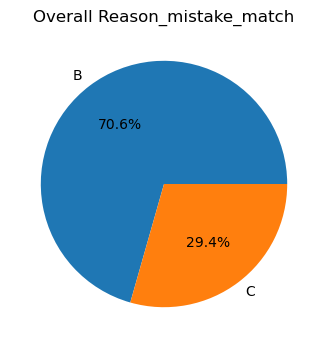

In [971]:
import matplotlib.pyplot as plt

overallmistake = nyc_google_dohmh[(nyc_google_dohmh['true_match'] == 0) & (nyc_google_dohmh['is_true_match'] == 1)]['Reason_miss_match'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(overallmistake, labels=overallmistake.index, autopct='%1.1f%%')
plt.title("Overall Reason_mistake_match")
plt.show()